In [19]:
still_fileNames = ['still_normal.txt', 'still_leftDown.txt', 'still_rightDown.txt', 'still_frontDown.txt',\
                 'still_backDown.txt', 'still_leftDownLean.txt', 'still_rightDownLean.txt',\
                 'still_frontDownLean.txt', 'still_backDownLean.txt']

moveUniform_fileNames = ['motion_xMove_uniform.txt', 'motion_xMove_uniform_slow.txt', 'motion_yMove_uniform.txt',\
                 'motion_yMove_uniform_slow.txt', 'motion_zMove_uniform.txt', 'motion_zMove_uniform_slow.txt']

for i in range(1,17):
    tmp_str = 'motion_xyz_Move_uniform' + str(i) + '.txt'
    moveUniform_fileNames.append(tmp_str)

#moveSpeedup_fileNames = ['motion_xyz_Move_speedup1.txt', 'motion_xyz_Move_speedup2.txt', \
#                         'motion_xyz_Move_speedup3.txt', 'motion_xyz_Move_speedup4.txt']

rotateSlowUniform_fileNames = ['multiStates.txt', 'multiStates2.txt', 'multiStates3.txt', 'multiStates4.txt']

rotateQuickUniform_fileNames = ['motion_xRotate_uniform_anticlock.txt', 'motion_xRotate_uniform_clock.txt',\
                 'motion_yRotate_uniform_anticlock.txt', 'motion_yRotate_uniform_clock.txt',\
                 'motion_zRotate_uniform_anticlock.txt', 'motion_zRotate_uniform_clock.txt',\
                 'motion_zRotate_uniform_anticlock_new.txt', 'motion_zRotate_uniform_clock_new.txt']

rotateMove_fileNames = ['motion_rotate_move1.txt', 'motion_rotate_move2.txt',\
                'motion_rotate_move3.txt', 'motion_rotate_move4.txt', 'motion_rotate_move5.txt',\
                'motion_rotate_move6.txt', 'motion_rotate_move7.txt', 'motion_rotate_move8.txt']


vibration_fileNames = []
for i in range(1, 21):
    tmp_str = 'motion_vibration' + str(i) + '.txt'
    vibration_fileNames.append(tmp_str)

    
moveSpeedup_fileNames = []
for i in range(1, 16):
    tmp_str = 'motion_xyz_Move_speedup' + str(i) + '.txt'
    moveSpeedup_fileNames.append(tmp_str)


# 静止状态下acc energy,gyr energy的幅度直方图，一个点为一个统计样本

Populating the interactive namespace from numpy and matplotlib


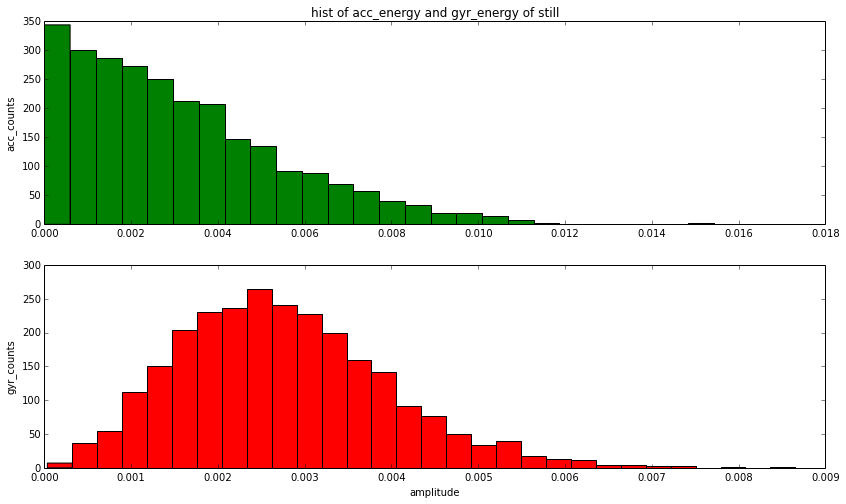

In [69]:
%pylab inline


pylab.rcParams['figure.figsize'] = (14.0, 8.0)

import numpy as np
import matplotlib.pyplot as plt
import logging

def correctBias(array):
    
    # set acc energy correct bias
    energy = energyXYZ(array)
    acc_energy = energy[:,0]
    gyr_energy = energy[:,1]
    #print gyr_energy
    
    correctBias_gyr(array[:, 3:6], gyr_energy)
    
    acc_energy_correctBias = correctBias_accEnergy(acc_energy, gyr_energy)
    array[:, 6] = acc_energy_correctBias


def correctBias_accEnergy(acc_energy, gyr_energy, interval=30):
    T_still_gyr_energy = 0.04
    
    acc_energy_avg = np.mean(acc_energy[:10])
    #acc_energy_avg = 1
    N = len(acc_energy)
    acc_energy_correctBias = np.zeros(N)
    
    for i in range(0, N, interval):
        acc_energy_seg = acc_energy[i:i+interval]
        gyr_energy_seg = gyr_energy[i:i+interval]
        # Still
        if sum(gyr_energy_seg >= T_still_gyr_energy) == 0:
            #print 'chenchong'
            acc_energy_avg = np.mean(acc_energy_seg)
        
        acc_energy_correctBias[i:i+interval] = np.sqrt((acc_energy_seg - acc_energy_avg)**2)
        
    return acc_energy_correctBias    


def correctBias_gyr(gyr_xyz, gyr_energy, interval=30):
    T_still_gyr_energy = 0.04
    
    gyr_x = gyr_xyz[:,0]
    gyr_y = gyr_xyz[:,1]
    gyr_z = gyr_xyz[:,2]
    
    N = len(gyr_energy)
    gyr_x_avg = np.mean(gyr_x[:10])
    gyr_y_avg = np.mean(gyr_y[:10])
    gyr_z_avg = np.mean(gyr_z[:10])
    #gyr_x_avg = 0
    #gyr_y_avg = 0
    #gyr_z_avg = 0
    
    for i in range(0, N, interval):
        gyr_energy_seg = gyr_energy[i:i+interval]
        if sum(gyr_energy_seg >= T_still_gyr_energy) == 0:
            
            gyr_x_avg = np.mean(gyr_x[i:i+interval])
            gyr_y_avg = np.mean(gyr_y[i:i+interval])
            gyr_z_avg = np.mean(gyr_z[i:i+interval])
        gyr_x[i:i+interval] -= gyr_x_avg
        gyr_y[i:i+interval] -= gyr_y_avg
        gyr_z[i:i+interval] -= gyr_z_avg


# Get the IMU signals from a file
def getSigs(fileName):
    fin = open(fileName)

    lines = fin.readlines()
    fin.close()
    
    res = []
    for str in lines:
        tmp = str.split()
        tmp = map(eval, tmp)
        res.append(tmp)

    res_array = np.array(res)
    res_array = res_array[10:, :]
    correctBias(res_array)
    
    return res_array

# Get labels corresponding sig
def getLabels(fileName):
    fin = open(fileName)
    lines = fin.readlines()
    fin.close()
    #print lines
    
    endpoint_label_list = []
    for line in lines:
        str_list = line.split(' ')
        int_list = map(int, str_list)
        endpoint_label_list.append(int_list)
    
    return endpoint_label_list


def extractSig(sigfilePath, labelfilePath):
    res = {}
    res[-1] = np.zeros((0,9))
    res[0] = np.zeros((0,9))
    res[1] = np.zeros((0,9))
    res[2] = np.zeros((0,9))
    res[3] = np.zeros((0,9))
    
    sig = getSigs(sigfilePath)
    endpoint_label_list = getLabels(labelfilePath)
    
    
    

    for tmp in endpoint_label_list:
        tmp_ind = range(tmp[0]-1, tmp[1])
        res[tmp[2]] = np.vstack((res[tmp[2]], sig[tmp_ind,:]))
    
    return res


def concatSigs(sig1, sig2):
    res = {}
    for k in sig1.keys():
        res[k] = np.vstack((sig1[k], sig2[k]))
        
    return res


# Calculate the 
def energyXYZ(array):
    energy_acc = np.sqrt(np.sum(array[:,0:3]**2, 1))
    energy_gyr = np.sqrt(np.sum(array[:,3:6]**2, 1))
    energy_mag = np.sqrt(np.sum(array[:,6:]**2, 1))
    tmp = np.array([energy_acc, energy_gyr, energy_mag])
    return np.transpose(tmp)



def concateMultiFiles(fileNames):
    dataDir = '../data/'
    labelDir = '../label/'
    
    
    res_specificClass = {}
    res_specificClass[-1] = np.zeros((0,9))
    res_specificClass[0] = np.zeros((0,9))
    res_specificClass[1] = np.zeros((0,9))
    res_specificClass[2] = np.zeros((0,9))
    res_specificClass[3] = np.zeros((0,9))
    
    for fileName in fileNames:
        #fileName = 'motion_rotate_move4.txt'
        sigfilePath = dataDir + fileName
        ind = fileName.find('.')
    
        if ind > -1:
            labelfilePath = labelDir + fileName[:ind] + '.label'
        else:
            logging.warning("wrong labelfilePath")
    
    
        res_1File = extractSig(sigfilePath, labelfilePath)
    
        res_specificClass = concatSigs(res_specificClass, res_1File)
        
    return res_specificClass
    

    
def calEntrophy(gyr_energy):
    gyr_energy_norm = gyr_energy/sum(gyr_energy)
    entropy = -sum(gyr_energy_norm * np.log(gyr_energy_norm))
    return entropy




def getEntrophy(energy, interval=30):
    N = len(energy)
    entrophy_list = []
    for i in range(0, N, interval):
        fragment = energy[i:i+interval]
        entrophy_list.append(calEntrophy(fragment))
    return np.array(entrophy_list)


from scipy import signal
def getEntrophy2(energy, interval=30):
    N = len(energy)
    entrophy_list = []
    for i in range(0, N, interval):
        fragment = energy[i:i+interval]
        fragment = signal.resample(fragment, 30)
        t = min(abs(fragment))
        fragment[fragment<0] = t
        entrophy_list.append(calEntrophy(fragment))
    return np.array(entrophy_list)
    

    
    
    
# Get the range of acc between of min and max
def getAccRange(acc_energy, interval=30):
    
    N = len(acc_energy)
    acc_energy_range = []
    for i in range(0,N,interval):
        fragment = acc_energy[i:i+interval]
        acc_energy_range.append(max(fragment) - min(fragment))
    return np.array(acc_energy_range)

def getAccForce(acc_energy, interval=30):
    N = len(acc_energy)
    acc_energy_range = []
    for i in range(0,N,interval):
        fragment = acc_energy[i:i+interval]
        acc_energy_range.append(max(fragment - 1))
    return np.array(acc_energy_range)

# Get the acc energy sum
def getAccEnergySum(acc_energy, interval=30):
        
    return getGyrEnergySum(acc_energy, interval)


def getGyrEnergySum(gyr_energy, interval=30):
    N = len(gyr_energy)
    gyr_energy_sum = []
    for i in range(0, N, interval):
        fragment = gyr_energy[i: i+interval]
        gyr_energy_sum.append(sum(fragment))
        
    return np.array(gyr_energy_sum)
    

def getAccMax(acc_energy, interval=30):
    return getGyrMax(acc_energy)

    
# Get the max value from interval of 30 points, Gyr
def getGyrMax(gyr_energy, interval=30):
    
    N = len(gyr_energy)
    gyr_energy_max = []
    for i in range(0, N, interval):
        fragment = gyr_energy[i:i+interval]
        gyr_energy_max.append(max(fragment))
    return np.array(gyr_energy_max)
        
    
def getEnergyStd(energy, interval=30):
    N = len(energy)
    energy_std = []
    for i in range(0, N, interval):
        fragment = energy[i:i+interval]
        energy_std.append(np.std(fragment))
    return np.array(energy_std)




def calmanFilter(z, R=0.05**2):
    N = len(z)
    
    Q = 1e-5
    
    xhat = np.zeros(N)
    P = np.zeros(N)
    xhatminus = np.zeros(N)
    Pminus = np.zeros(N)
    K = np.zeros(N)
    
    xhat[0] = z[0]
    P[0] = 1.0
    
    
    for k in range(1, N):
        # time update
        xhatminus[k] = xhat[k-1]  #X(k|k-1) = AX(k-1|k-1) + BU(k) + W(k),A=1,BU(k) = 0
        Pminus[k] = P[k-1]+Q      #P(k|k-1) = AP(k-1|k-1)A' + Q(k) ,A=1

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R ) #Kg(k)=P(k|k-1)H'/[HP(k|k-1)H' + R],H=1
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k]) #X(k|k) = X(k|k-1) + Kg(k)[Z(k) - HX(k|k-1)], H=1
        P[k] = (1-K[k])*Pminus[k] #P(k|k) = (1 - Kg(k)H)P(k|k-1), H=1
    
    return xhat


if __name__ == '__main__':
      
    #fileNames = ['still_normal.txt', 'still_leftDown.txt', 'still_rightDown.txt', 'still_frontDown.txt',\
    #             'still_backDown.txt', 'still_leftDownLean.txt', 'still_rightDownLean.txt',\
    #             'still_frontDownLean.txt', 'still_backDownLean.txt']
    fileNames = still_fileNames
    
    res_specificClass = concateMultiFiles(fileNames)
    
    
    sig_still = res_specificClass[0]
    energy_still = energyXYZ(sig_still)
    
    #plt.plot(sig_still[:,6])
    #plt.show()
    
    
    #print max(sig_still[:,6])
     
    fig,ax = plt.subplots(2)
    ax[0].hist(sig_still[:,6], 30, facecolor='g')
    ax[0].set_ylabel('acc_counts')
    ax[1].hist(energy_still[:,1], 30, facecolor='r')
    ax[1].set_xlabel('amplitude')
    ax[1].set_ylabel('gyr_counts')
    ax[0].set_title('hist of acc_energy and gyr_energy of still')
    
    
                                                                                        
                                                                       
                                                                                
    

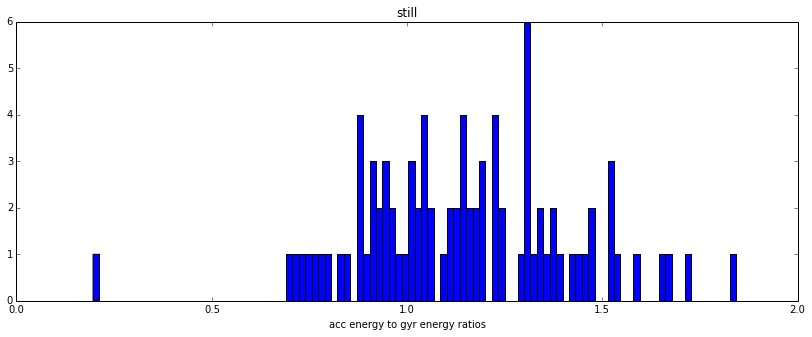

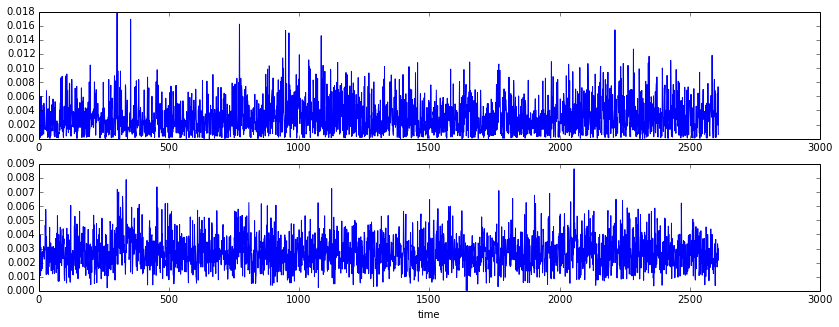

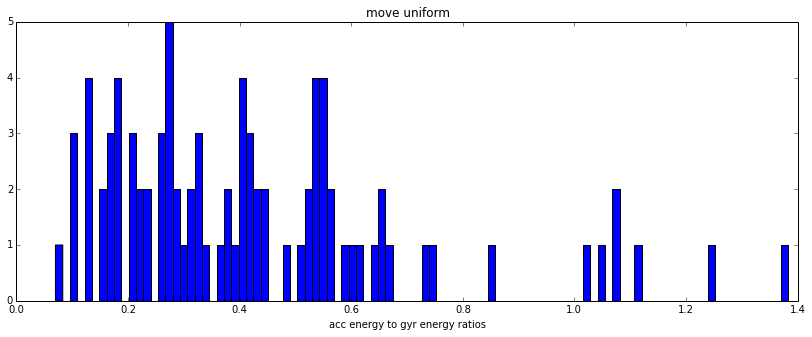

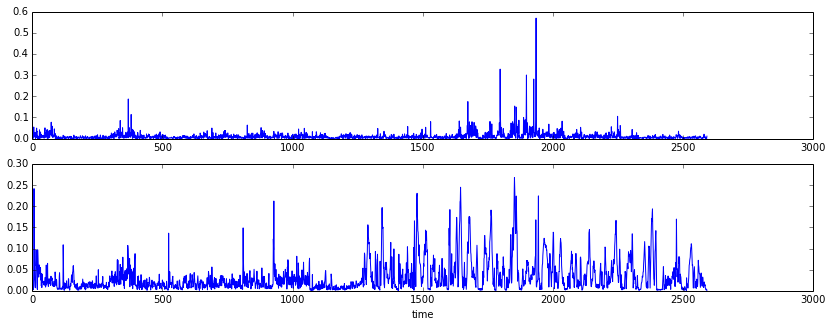

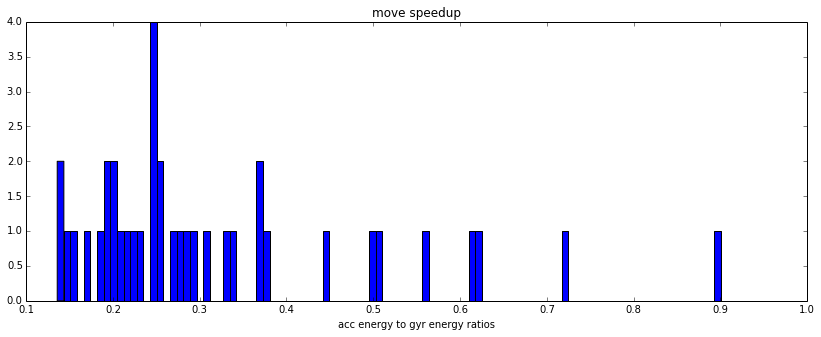

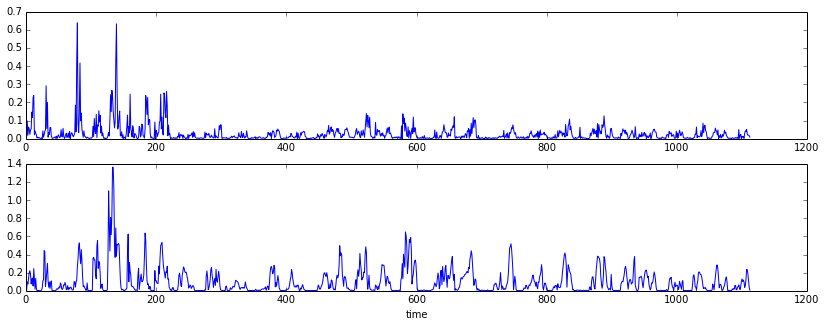

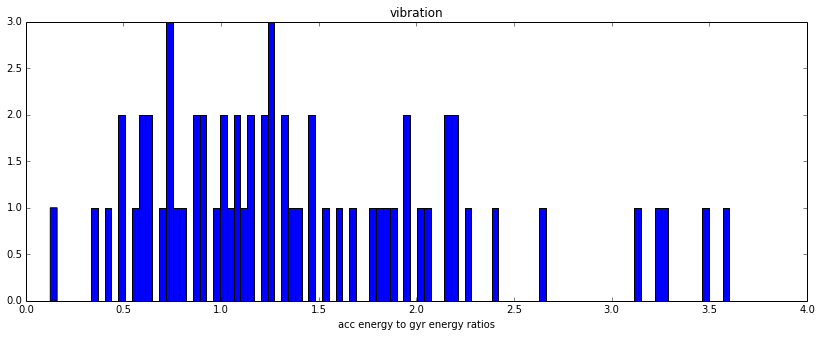

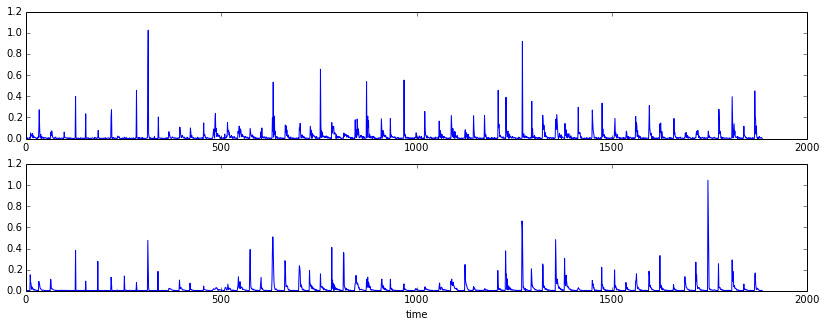

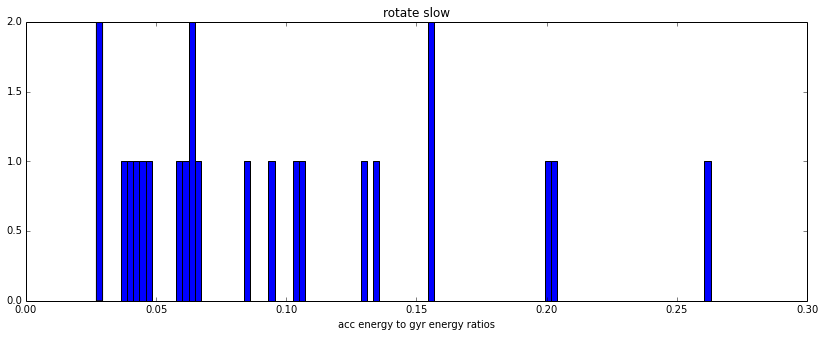

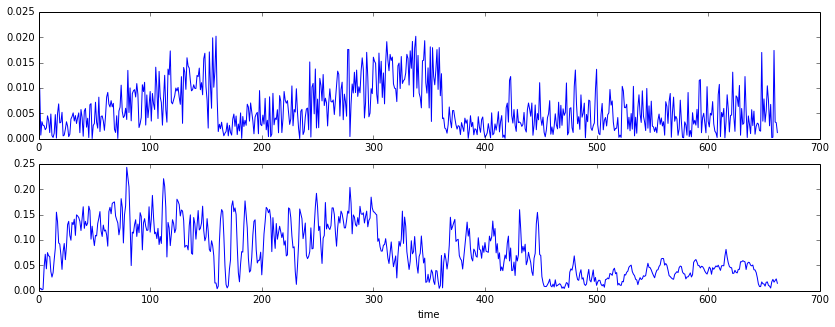

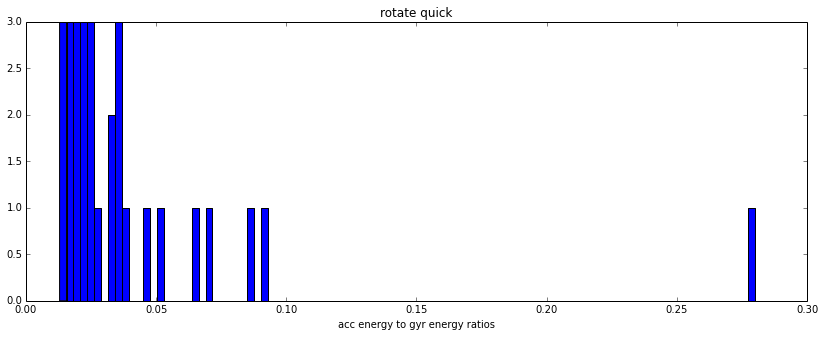

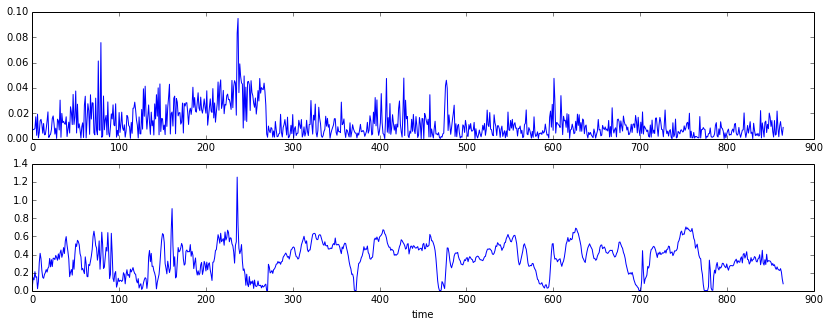

In [21]:
def energy_acc_gyr_ratio(energy_acc, energy_gyr, interval=30):
    N = len(energy_acc)
    ratios = []
    for i in range(0, N, interval):
        energy_acc_frag = energy_acc[i:i+interval]
        energy_gyr_frag = energy_gyr[i:i+interval]
        ratios.append(sum(energy_acc_frag)/sum(energy_gyr_frag))
        
    return np.array(ratios)
    

pylab.rcParams['figure.figsize'] = (14.0, 5.0)
if __name__ == '__main__':
      
    fileNames_list = [still_fileNames, moveUniform_fileNames, moveSpeedup_fileNames, vibration_fileNames,\
                      rotateSlowUniform_fileNames, rotateQuickUniform_fileNames]
    titles_list = ['still', 'move uniform', 'move speedup', 'vibration', 'rotate slow', 'rotate quick']
    
    type = [0,1,1,-1,2,2]
    
    for i in range(len(fileNames_list)):
        
        #fileNames = still_fileNames
        fileNames = fileNames_list[i]
        res_specificClass = concateMultiFiles(fileNames)
    
    
        sig_still = res_specificClass[type[i]]
        energy_still = energyXYZ(sig_still)
    
        ratios = energy_acc_gyr_ratio(sig_still[:,6], energy_still[:,1])
        plt.hist(ratios, 100)
        plt.xlabel('acc energy to gyr energy ratios')
        plt.title(titles_list[i])
    
        fig, ax = plt.subplots(2)
        ax[0].plot(sig_still[:,6])
        ax[1].plot(energy_still[:,1])
        ax[1].set_xlabel('time')
        plt.show()
    
                                                   

# 静止状态下acc max,gyr max的幅度直方图，30个点为一个统计样本

(2611, 3)


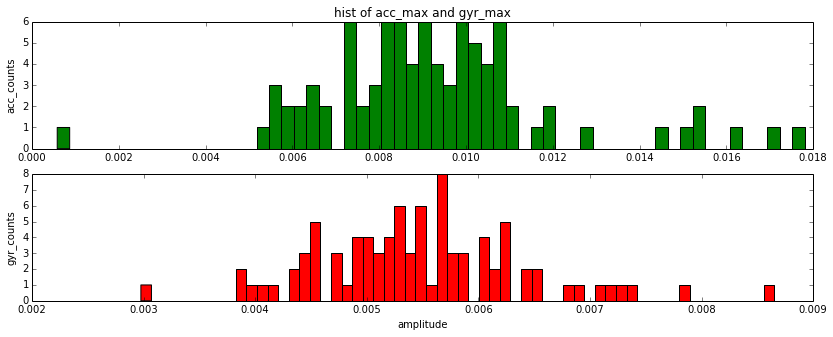

In [22]:
if __name__ == '__main__':
      
    
    fileNames = still_fileNames
    res_specificClass = concateMultiFiles(fileNames)
    
    
    sig_still = res_specificClass[0]
    energy_still = energyXYZ(sig_still)
    
    
    print energy_still.shape
    
    energy_still_acc_Max = getAccMax(sig_still[:,6])
    energy_still_gyr_max = getGyrMax(energy_still[:,1])
     
    fig,ax = plt.subplots(2)
    ax[0].hist(energy_still_acc_Max, 60, facecolor='g')
    ax[0].set_ylabel('acc_counts')
    ax[1].hist(energy_still_gyr_max, 60, facecolor='r')
    ax[1].set_xlabel('amplitude')
    ax[1].set_ylabel('gyr_counts')
    ax[0].set_title('hist of acc_max and gyr_max')
                                                   

# 静止状态下acc,gyr的幅度直方图，45个点为一个统计样本

(2611, 3)


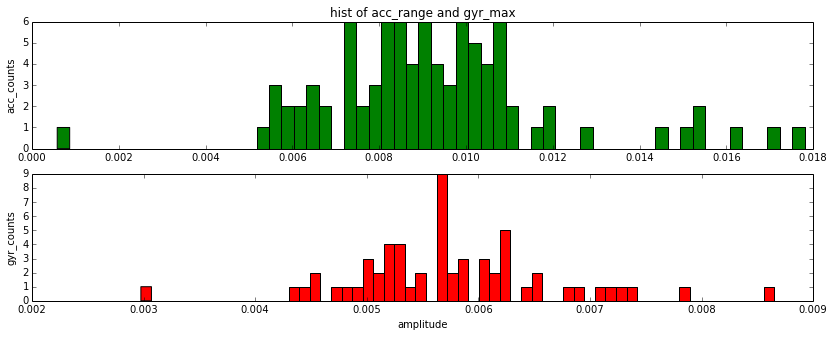

In [23]:
if __name__ == '__main__':
      
    
    fileNames = still_fileNames
    res_specificClass = concateMultiFiles(fileNames)
    
    
    sig_still = res_specificClass[0]
    energy_still = energyXYZ(sig_still)
    
    
    print energy_still.shape
    
    frag_len = 45
    energy_still_acc_range = getAccMax(sig_still[:,6], frag_len)
    energy_still_gyr_max = getGyrMax(energy_still[:,1], frag_len)
     
    fig,ax = plt.subplots(2)
    ax[0].hist(energy_still_acc_range, 60, facecolor='g')
    ax[0].set_ylabel('acc_counts')
    ax[1].hist(energy_still_gyr_max, 60, facecolor='r')
    ax[1].set_xlabel('amplitude')
    ax[1].set_ylabel('gyr_counts')
    ax[0].set_title('hist of acc_range and gyr_max')
                                                   

# 比较各种类型still下的统计图（比如说rotate后面的still）30个点为一个样本
* 可以发现acc energy max区别不大，幅值基本都在0.02之内，可以作为运动与静止的分界线阈值,但是不少收其它运动影响，在<0.1范围内
* 但是gyr energy max 区别有些大，特别是move_still,rotate_still的幅值偏大，说明rotate,move对still具有一定的影响

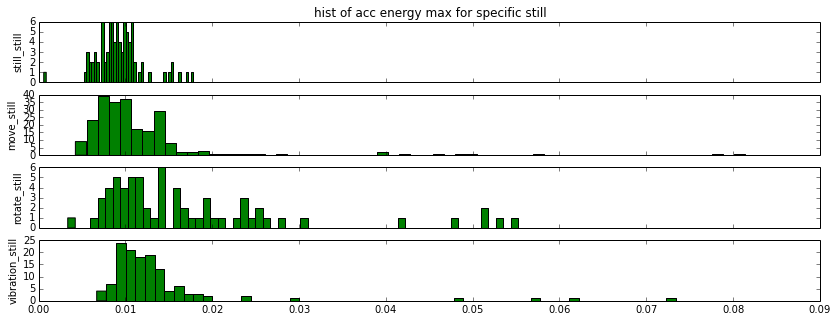

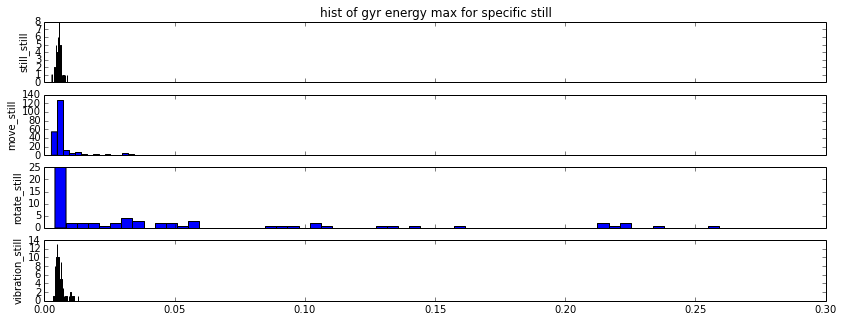

In [24]:
if __name__ == '__main__':
    
    
    fileNames1 = still_fileNames
    
    fileNames2 = []
    fileNames2.extend(moveUniform_fileNames)
    fileNames2.extend(moveSpeedup_fileNames)
    
    fileNames3 = []
    fileNames3.extend(rotateSlowUniform_fileNames)
    fileNames3.extend(rotateQuickUniform_fileNames)
    
    fileNames4 = vibration_fileNames
    
    res_still = concateMultiFiles(fileNames1)
    res_move = concateMultiFiles(fileNames2)
    res_rotate = concateMultiFiles(fileNames3)
    res_vibration = concateMultiFiles(fileNames4)
    
    
    still_still = res_still[0]
    move_still = res_move[0]
    rotate_still = res_rotate[0]
    vibration_still = res_vibration[0]
    
    energy_still_still = energyXYZ(still_still)
    energy_move_still = energyXYZ(move_still)
    energy_rotate_still = energyXYZ(rotate_still)
    energy_vibration_still = energyXYZ(vibration_still)
    
    accRange_still_still = getAccMax(still_still[:,6])
    accRange_move_still = getAccMax(move_still[:,6])
    accRange_rotate_still = getAccMax(rotate_still[:,6])
    accRange_vibration_still = getAccMax(vibration_still[:,6])
    
    
    gyrMax_still_still = getGyrMax(energy_still_still[:,1])
    gyrMax_move_still = getGyrMax(energy_move_still[:,1])
    gyrMax_rotate_still = getGyrMax(energy_rotate_still[:,1])
    gyrMax_vibration_still = getGyrMax(energy_vibration_still[:,1])
        
        
    fig,ax = plt.subplots(4, sharex=True)
    ax[0].hist(accRange_still_still, 60, facecolor='g')
    ax[0].set_ylabel('still_still')
    ax[1].hist(accRange_move_still, 60, facecolor='g')
    #ax[1].set_xlabel('amplitude')
    ax[1].set_ylabel('move_still')
    ax[2].hist(accRange_rotate_still, 60, facecolor='g')
    ax[2].set_ylabel('rotate_still')
    ax[3].hist(accRange_vibration_still, 60, facecolor='g')
    ax[3].set_ylabel('vibration_still')
    ax[0].set_title('hist of acc energy max for specific still')
    
    
    fig2,ax2 = plt.subplots(4, sharex=True)
    ax2[0].hist(gyrMax_still_still, 60)
    ax2[0].set_ylabel('still_still')
    ax2[1].hist(gyrMax_move_still, 60)
    ax2[1].set_ylabel('move_still')
    ax2[2].hist(gyrMax_rotate_still, 60)
    ax2[2].set_ylabel('rotate_still')
    ax2[3].hist(gyrMax_vibration_still, 60)
    ax2[3].set_ylabel('vibration_still')
    ax2[0].set_title('hist of gyr energy max for specific still')
    
                                                                                        
                                                             

#比较rotate和still的gyr energy sum, 30点为单位

(1792, 3)
(12264, 3)


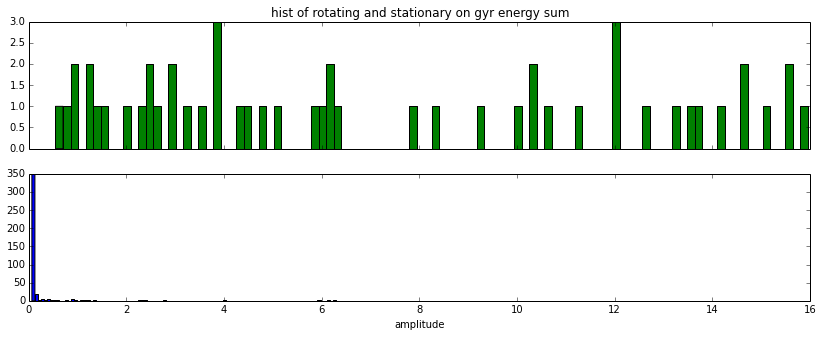

In [25]:
if __name__ == '__main__':
    
    
    
    fileNames = []
    fileNames.extend(still_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    #fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_rotate = res_specificClass[2]
    sig_still = res_specificClass[0]
    
    energy_rotate = energyXYZ(sig_rotate)
    energy_still = energyXYZ(sig_still)
    
    energy_rotate_gyr_sum = getGyrEnergySum(energy_rotate[:,1])
    energy_still_gyr_sum = getGyrEnergySum(energy_still[:,1])
    
    print energy_move_uniform.shape
    print energy_still.shape
    
    
    fig2,ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(energy_rotate_gyr_sum, 100, facecolor='g')
    ax2[1].hist(energy_still_gyr_sum, 100, facecolor='b')
    ax2[1].set_xlabel('amplitude')
    ax2[0].set_title('hist of rotating and stationary on gyr energy sum')
    
    
    
                                                                                        

#比较rotate uniform和moving uniform的gyr energy sum, 30点为单位



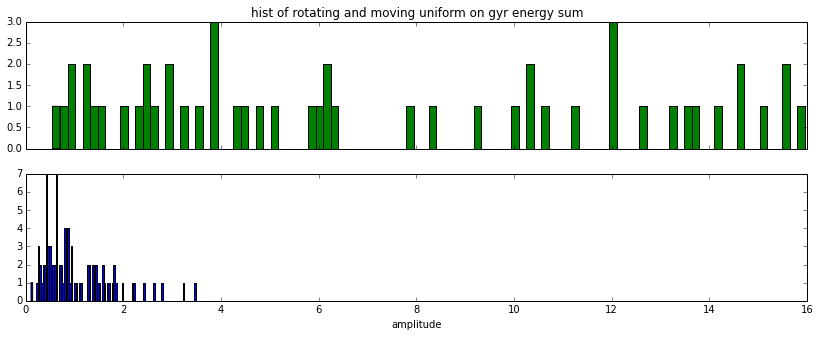

In [26]:
if __name__ == '__main__':
    
    
    
    fileNames = []
    fileNames.extend(still_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    #fileNames.extend(moveSpeedup_fileNames)
    #fileNames.extend(vibration_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_rotate = res_specificClass[2]
    sig_moveUniform = res_specificClass[1]
    
    energy_rotate = energyXYZ(sig_rotate)
    energy_moveUniform = energyXYZ(sig_moveUniform)
    
    energy_rotate_gyr_sum = getGyrEnergySum(energy_rotate[:,1])
    energy_moveUniform_gyr_sum = getGyrEnergySum(energy_moveUniform[:,1])
    
    
    fig2,ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(energy_rotate_gyr_sum, 100, facecolor='g')
    ax2[1].hist(energy_moveUniform_gyr_sum, 100, facecolor='b')
    ax2[1].set_xlabel('amplitude')
    ax2[0].set_title('hist of rotating and moving uniform on gyr energy sum')
    
    
    
                                                                                        

#比较rotate speedup和moving speedup的gyr energy sum, 30点为单位


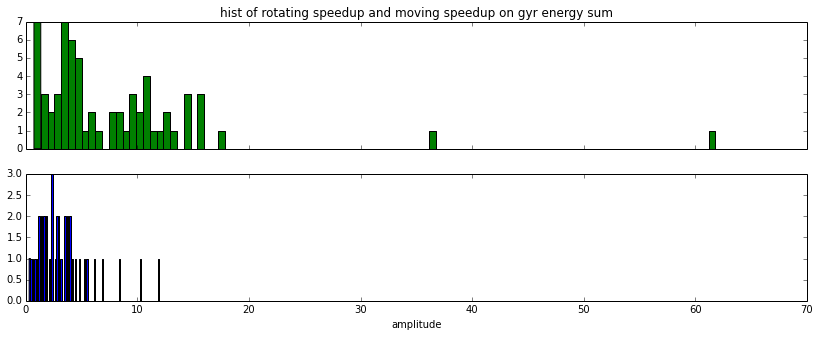

In [27]:
if __name__ == '__main__':
    
    
    
    fileNames = []
    fileNames.extend(still_fileNames)
    #fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateMove_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_rotate = res_specificClass[2]
    sig_moveUniform = res_specificClass[1]
    
    energy_rotate = energyXYZ(sig_rotate)
    energy_moveUniform = energyXYZ(sig_moveUniform)
    
    energy_rotate_gyr_sum = getGyrEnergySum(energy_rotate[:,1])
    energy_moveUniform_gyr_sum = getGyrEnergySum(energy_moveUniform[:,1])
    
    
    fig2,ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(energy_rotate_gyr_sum, 100, facecolor='g')
    ax2[1].hist(energy_moveUniform_gyr_sum, 100, facecolor='b')
    ax2[1].set_xlabel('amplitude')
    ax2[0].set_title('hist of rotating speedup and moving speedup on gyr energy sum')
    
    
    
                                                                                        

# 比较匀速Moving和Still, 一个点为一个单位


(2592, 3)
(8350, 3)


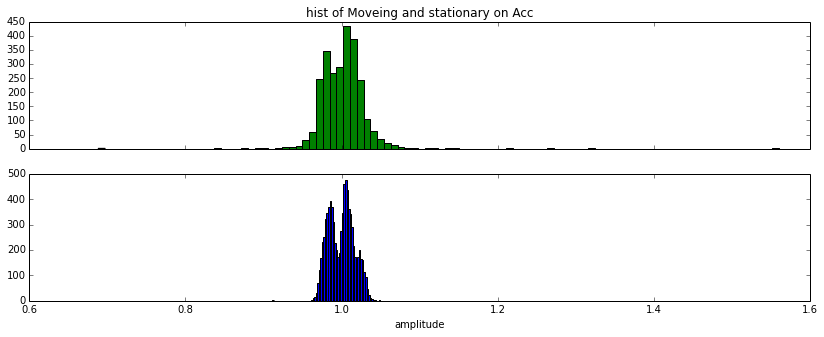

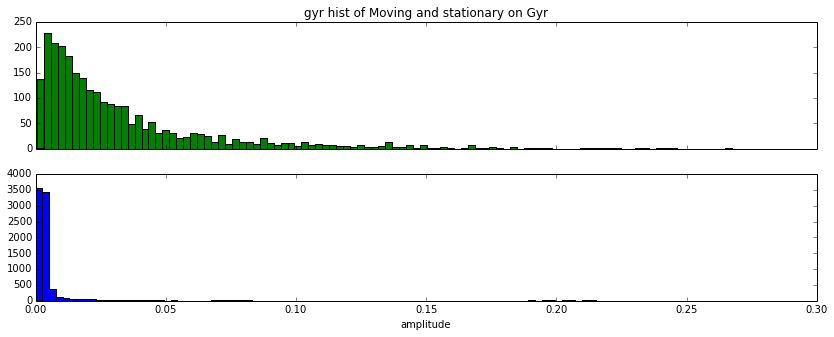

In [28]:
if __name__ == '__main__':
    
    
    
    fileNames = []
    fileNames.extend(still_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_move_uniform = res_specificClass[1]
    sig_still = res_specificClass[0]
    
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_still = energyXYZ(sig_still)
    
    print energy_move_uniform.shape
    print energy_still.shape
    
    
    
    
    
    
    fig2,ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(energy_move_uniform[:,0], 100, facecolor='g')
    ax2[1].hist(energy_still[:,0], 100, facecolor='b')
    ax2[1].set_xlabel('amplitude')
    ax2[0].set_title('hist of Moveing and stationary on Acc')
    
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(energy_move_uniform[:,1], 100, facecolor='g')
    ax[1].hist(energy_still[:,1], 100, facecolor='b')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('gyr hist of Moving and stationary on Gyr')
                                                                                        

# 比较匀(加)速Moving和Still, 基于acc和gyr信号能量，一个点为一个单位


(3958, 3)
(12907, 3)


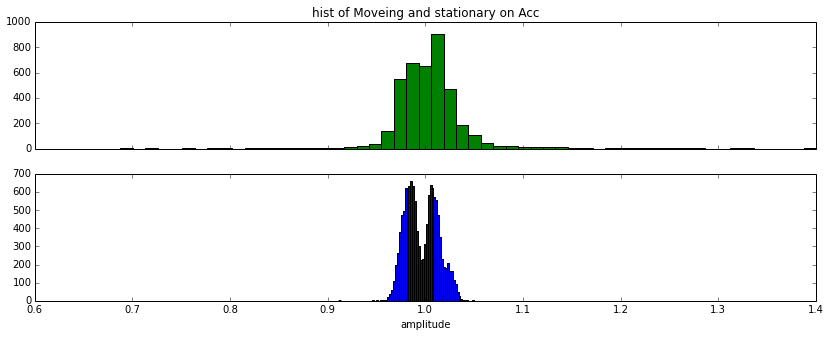

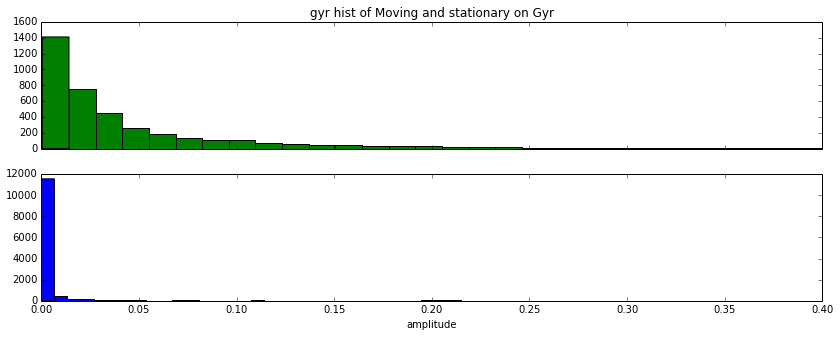

In [29]:
if __name__ == '__main__':
    
    
    
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(still_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(rotateMove_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_move_uniform = res_specificClass[1]
    sig_still = res_specificClass[0]
    
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_still = energyXYZ(sig_still)
    
    print energy_move_uniform.shape
    print energy_still.shape
    
    
    
    fig2,ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(energy_move_uniform[:,0], 100, facecolor='g')
    ax2[1].hist(energy_still[:,0], 100, facecolor='b')
    ax2[1].set_xlabel('amplitude')
    ax2[0].set_title('hist of Moveing and stationary on Acc')
    ax2[1].set_xlim([0.6,1.4])
    
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(energy_move_uniform[:,1], 100, facecolor='g')
    ax[1].hist(energy_still[:,1], 100, facecolor='b')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('gyr hist of Moving and stationary on Gyr')
    ax[1].set_xlim([0,0.4])
                                                                                        

# 比较匀速Moving和Still, 基于ACC_energy的max, Gyr_energy的max, 30点一个单位

(2592, 3)
(8350, 3)


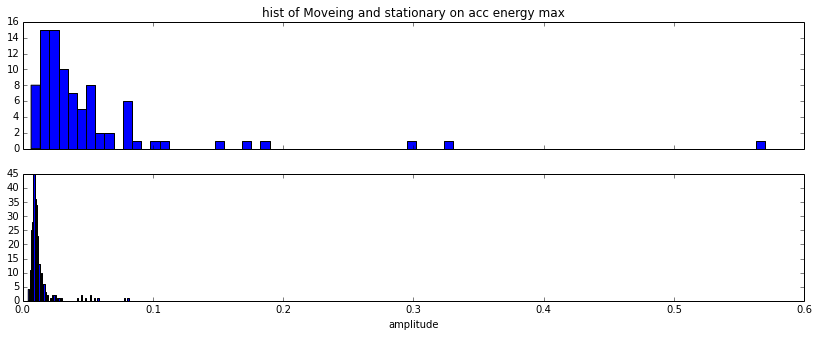

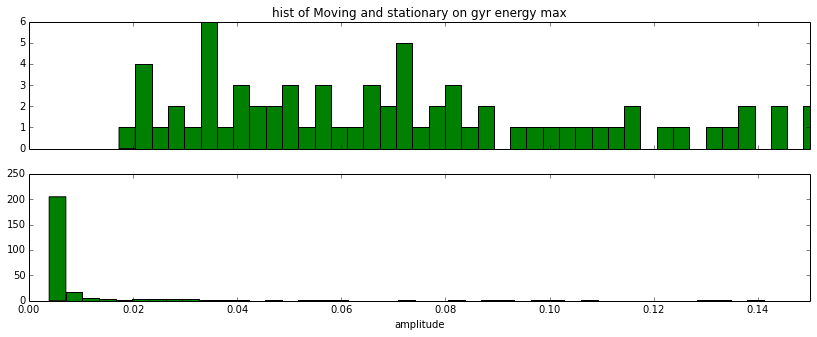

In [30]:
if __name__ == '__main__':
    
    
    
    fileNames = []
    fileNames.extend(still_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_move_uniform = res_specificClass[1]
    sig_still = res_specificClass[0]
    
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_still = energyXYZ(sig_still)
    
    print energy_move_uniform.shape
    print energy_still.shape
    
    acc_energyRange_move_uniform = getAccMax(sig_move_uniform[:,6])
    acc_energyRange_still = getAccMax(sig_still[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_move_uniform, 80, facecolor='b')
    ax[1].hist(acc_energyRange_still, 80, facecolor='b')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of Moveing and stationary on acc energy max')
    
    
    
    gyr_energyMax_move_uniform = getGyrMax(energy_move_uniform[:,1])
    gyr_energyMax_still_uniform = getGyrMax(energy_still[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_move_uniform, 80, facecolor='g')
    ax2[1].hist(gyr_energyMax_still_uniform, 80, facecolor='g')
    ax2[0].set_title('hist of Moving and stationary on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    ax2[1].set_xlim([0, 0.15])
                                                          

# 比较匀速移动和still，30点为一个单位，片段中的总能量
**可以发现gyr的energy sum更具有区分性，阈值可以设在0.2左右**

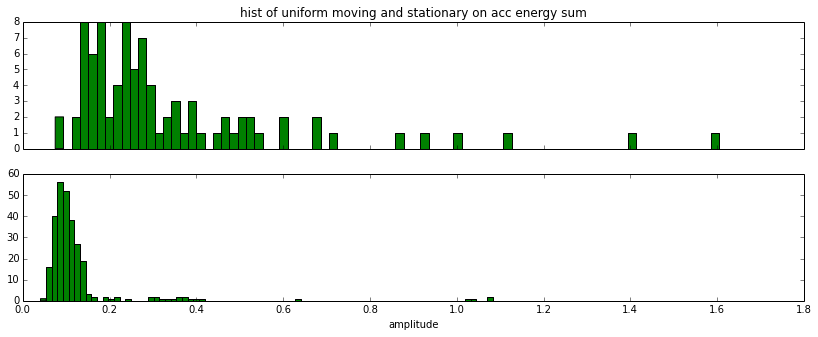

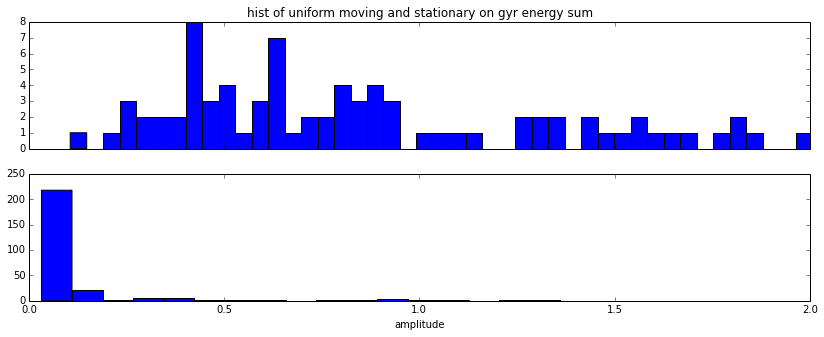

In [31]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(still_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[1]
    sig2 = res_specificClass[0]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getGyrEnergySum(sig1[:,6])
    acc_energyRange_sig2 = getGyrEnergySum(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of uniform moving and stationary on acc energy sum')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrEnergySum(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrEnergySum(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of uniform moving and stationary on gyr energy sum')
    ax2[1].set_xlabel('amplitude')
    ax2[1].set_xlim([0, 2])
                                                          

#比较uniform moving和still的acc和gyr的energy标准差, 30点一个sample 

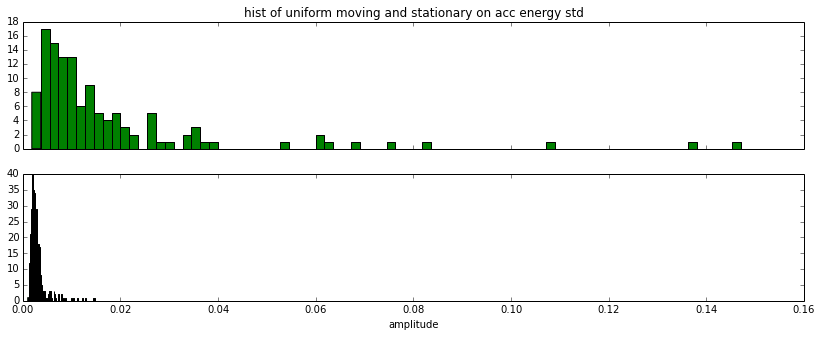

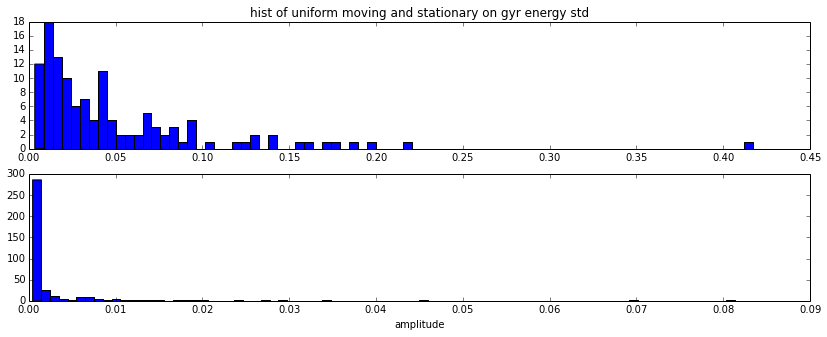

In [32]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(still_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[1]
    sig2 = res_specificClass[0]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    acc_energyStd_sig1 = getEnergyStd(sig1[:,6])
    acc_energyStd_sig2 = getEnergyStd(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyStd_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyStd_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of uniform moving and stationary on acc energy std')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyStd_sig1 = getEnergyStd(energy_sig1[:,1])
    gyr_energyStd_sig2 = getEnergyStd(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=False)
    ax2[0].hist(gyr_energyStd_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyStd_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of uniform moving and stationary on gyr energy std')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 0.6])
                                                          

# 比较匀(加)速Moving和Still, 基于ACC_energy的max, Gyr_energy的max, 30采样一个sample

(3958, 3)
(12907, 3)


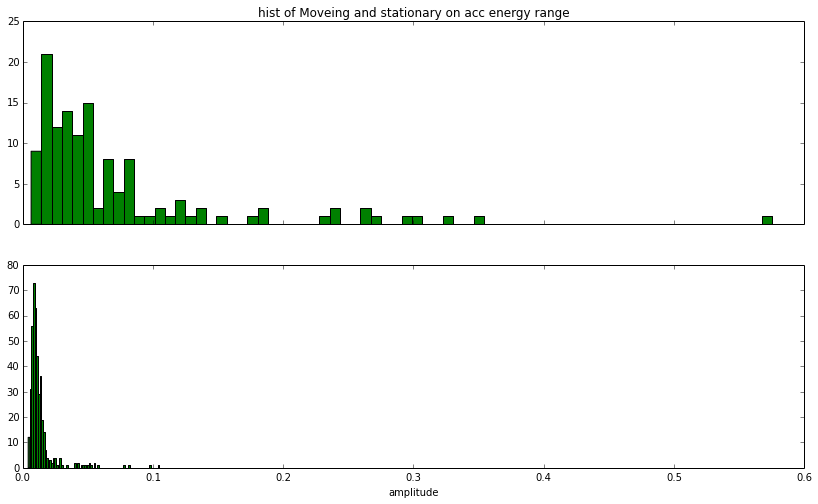

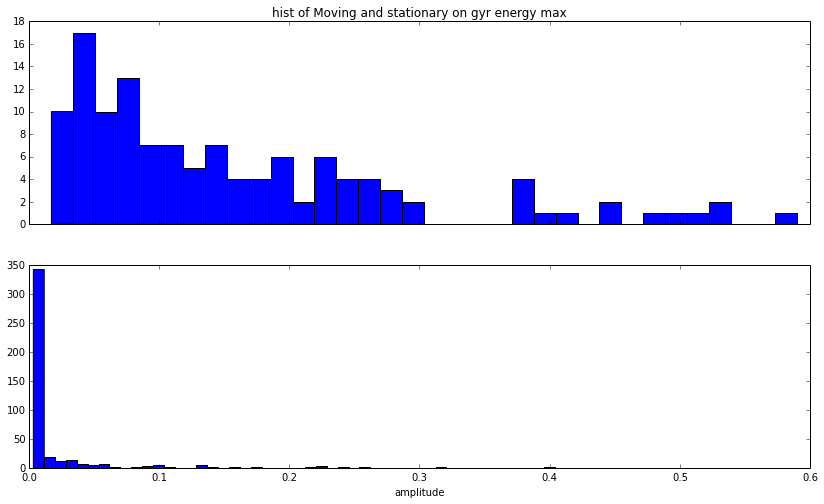

In [56]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(still_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(rotateMove_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig_move_uniform = res_specificClass[1]
    sig_still = res_specificClass[0]
    
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_still = energyXYZ(sig_still)
    
    print energy_move_uniform.shape
    print energy_still.shape
    
    acc_energyRange_move_uniform = getAccMax(sig_move_uniform[:,6])
    acc_energyRange_still = getAccMax(sig_still[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_move_uniform, 80, facecolor='g')
    ax[1].hist(acc_energyRange_still, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of Moveing and stationary on acc energy range')
    ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_move_uniform = getGyrMax(energy_move_uniform[:,1])
    gyr_energyMax_still_uniform = getGyrMax(energy_still[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_move_uniform, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_still_uniform, 80, facecolor='b')
    ax2[0].set_title('hist of Moving and stationary on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    ax2[1].set_xlim([0, 0.6])
                                                          

# 比较加速Moving和匀速Moving, 基于ACC_energy的max, Gyr_energy的max, 30采样一个sample

(2592, 3)
(1113, 3)


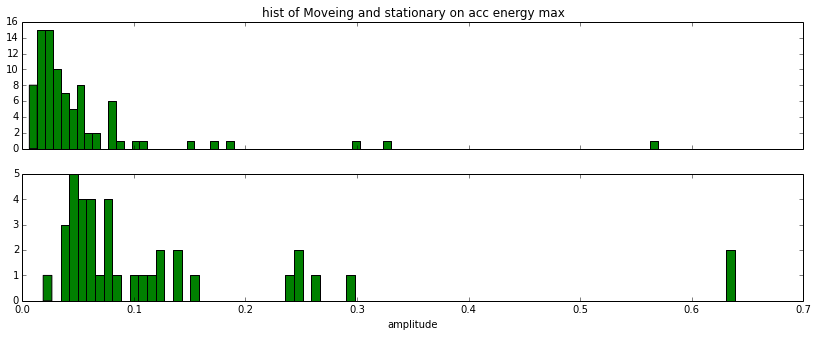

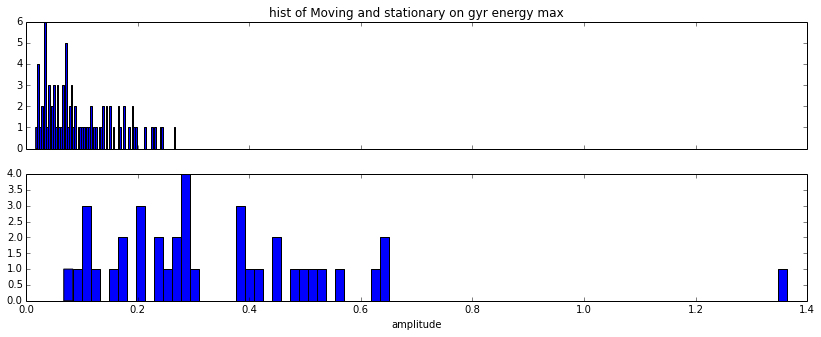

In [34]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames2 = []
    fileNames.extend(moveUniform_fileNames)
    fileNames2.extend(moveSpeedup_fileNames)
    

    res_specificClass = concateMultiFiles(fileNames)
    res_specificClass2 = concateMultiFiles(fileNames2)
    
    sig_move_uniform = res_specificClass[1]
    sig_move_speedup = res_specificClass2[1]
    
    
    
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_move_speedup = energyXYZ(sig_move_speedup)
    
    
    
    
    print energy_move_uniform.shape
    print energy_move_speedup.shape
    
    acc_energyRange_move_uniform = getAccMax(sig_move_uniform[:,6])
    acc_energyRange_move_speedup = getAccMax(sig_move_speedup[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_move_uniform, 80, facecolor='g')
    ax[1].hist(acc_energyRange_move_speedup, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of Moveing and stationary on acc energy max')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_move_uniform = getGyrMax(energy_move_uniform[:,1])
    gyr_energyMax_move_speedup = getGyrMax(energy_move_speedup[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_move_uniform, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_move_speedup, 80, facecolor='b')
    ax2[0].set_title('hist of Moving and stationary on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 0.6])
                                                          

# 比较低匀速rotating和still, 30采样点一个单位

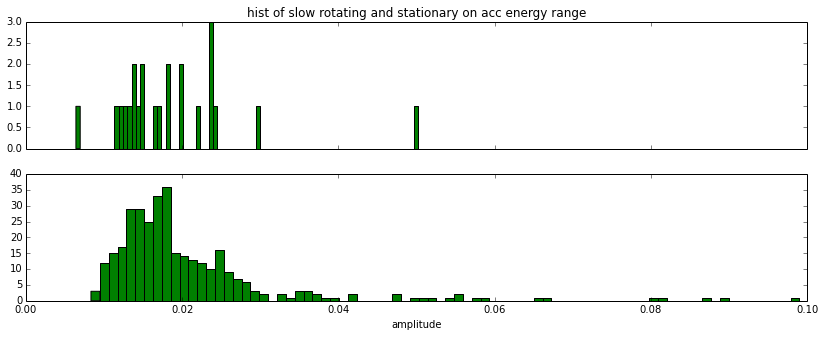

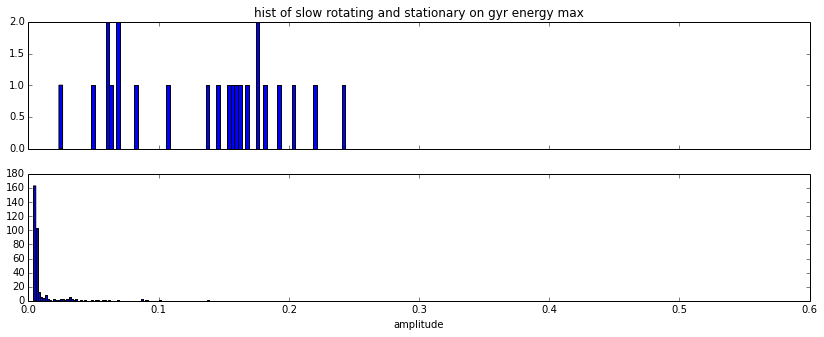

In [35]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(still_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    #fileNames.extend(rotateQuickUniform_fileNames)
    #fileNames.extend(rotateMove_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[2]
    sig2 = res_specificClass[0]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccRange(energy_sig1[:,0])
    acc_energyRange_sig2 = getAccRange(energy_sig2[:,0])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of slow rotating and stationary on acc energy range')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrMax(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrMax(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of slow rotating and stationary on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    ax2[1].set_xlim([0, 0.6])
                                                          

# 比较低+高匀速rotating和still, 30采样点一个单位

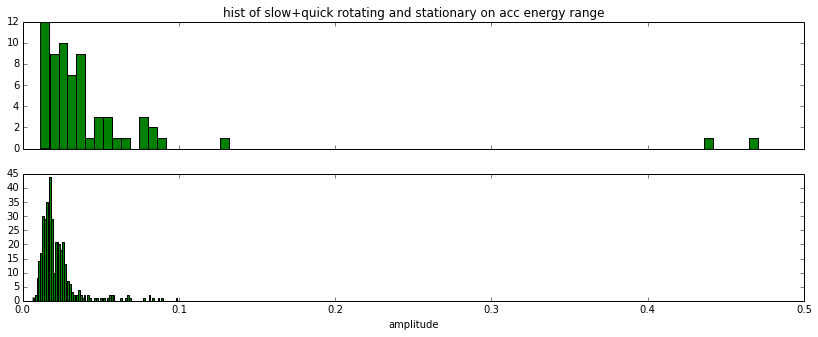

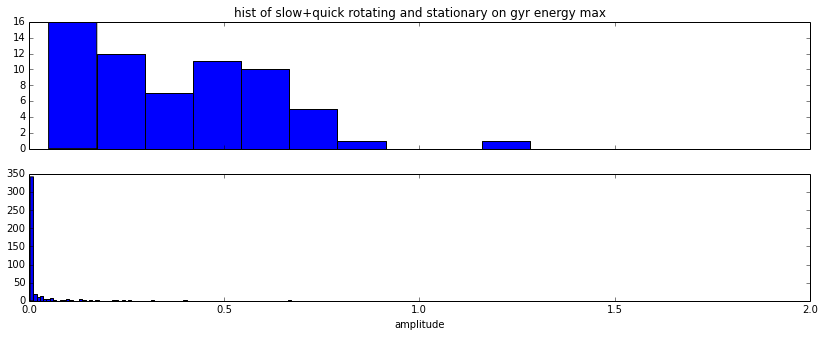

In [36]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(still_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(rotateMove_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[2]
    sig2 = res_specificClass[0]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccRange(energy_sig1[:,0])
    acc_energyRange_sig2 = getAccRange(energy_sig2[:,0])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of slow+quick rotating and stationary on acc energy range')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrMax(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrMax(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of slow+quick rotating and stationary on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    ax2[1].set_xlim([0, 2])
                                                          

#比较vibration和still, 1个点为一单位

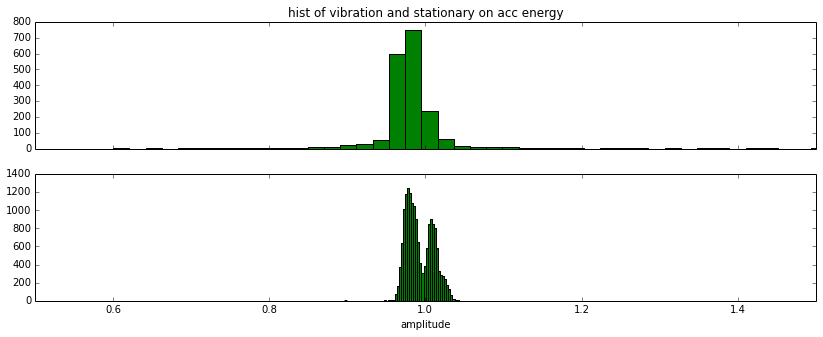

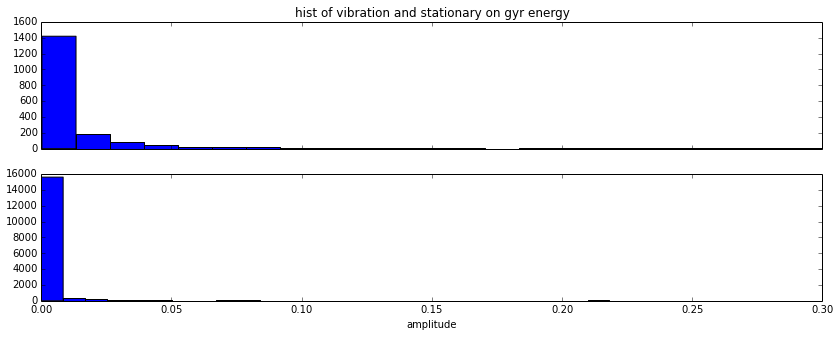

In [37]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(still_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(rotateMove_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    #acc_energyRange_sig1 = getAccRange(energy_sig1[:,0])
    #acc_energyRange_sig2 = getAccRange(energy_sig2[:,0])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(energy_sig1[:,0], 80, facecolor='g')
    ax[1].hist(energy_sig2[:,0], 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and stationary on acc energy')
    ax[0].set_xlim([0.5,1.5])
    
    
    
    #gyr_energyMax_sig1 = getGyrMax(energy_sig1[:,1])
    #gyr_energyMax_sig2 = getGyrMax(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(energy_sig1[:,1], 80, facecolor='b')
    ax2[1].hist(energy_sig2[:,1], 80, facecolor='b')
    ax2[0].set_title('hist of vibration and stationary on gyr energy')
    ax2[1].set_xlabel('amplitude')
    ax2[1].set_xlim([0, 0.3])
                                                          

# 比较vibration和still，30个点一个单位,基于acc energy max, gyr energy max
* acc energy max 区别较为明显

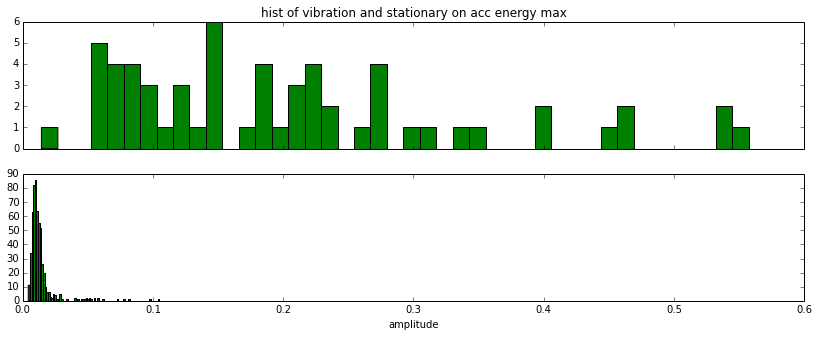

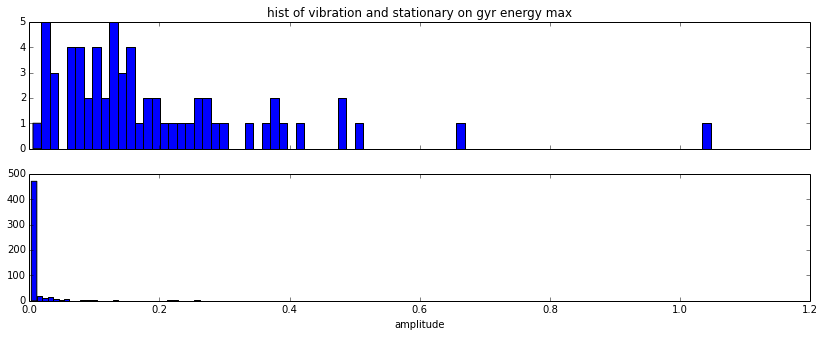

In [38]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(still_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(rotateMove_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccMax(sig1[:,6])
    acc_energyRange_sig2 = getAccMax(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and stationary on acc energy max')
    ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrMax(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrMax(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of vibration and stationary on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

#比较vibration和moving uniform, 30个点为一个单位,基于acc max, gyr max

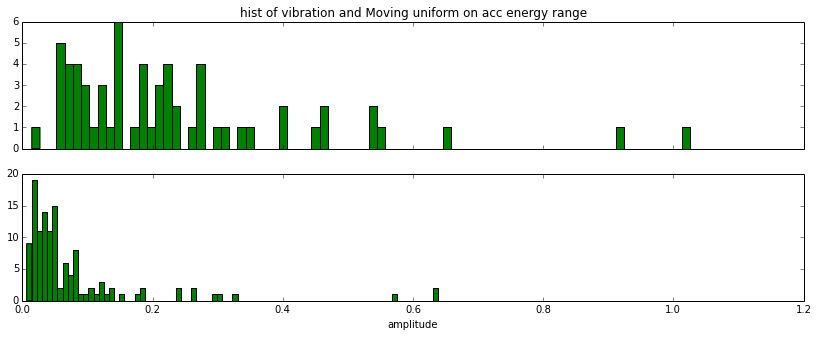

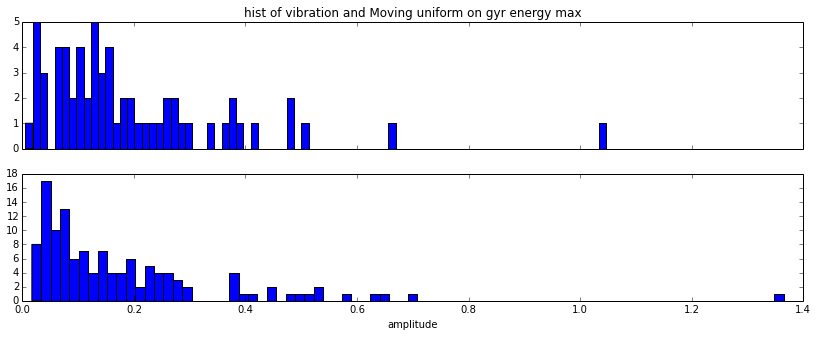

In [40]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccMax(sig1[:,6])
    acc_energyRange_sig2 = getAccMax(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and Moving uniform on acc energy range')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrMax(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrMax(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of vibration and Moving uniform on gyr energy max')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

#比较vibration和moving uniform, 30个点为一个单位,基于acc energy sum, gyr energy sum

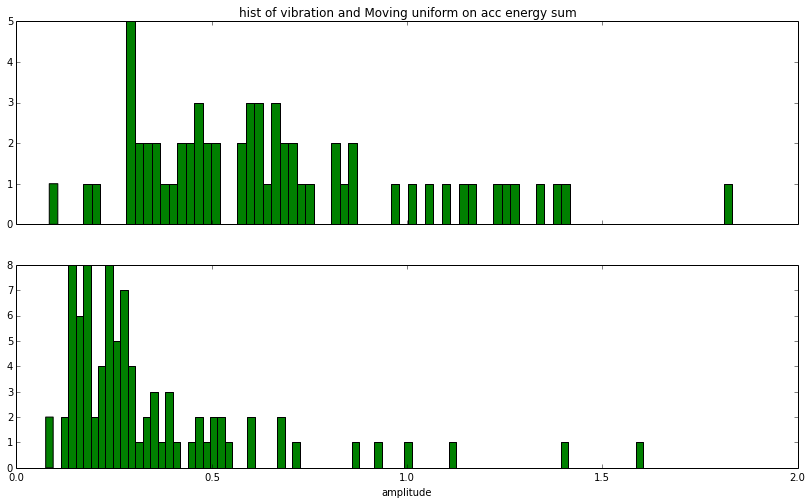

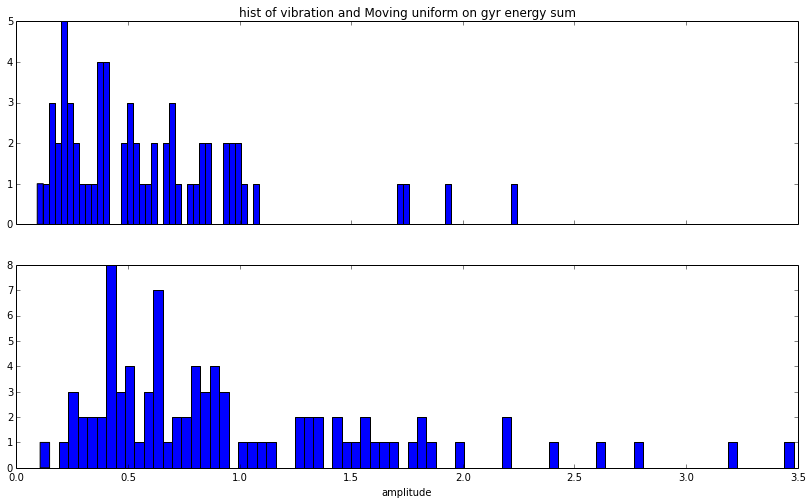

In [59]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    #fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccEnergySum(sig1[:,6])
    acc_energyRange_sig2 = getAccEnergySum(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and Moving uniform on acc energy sum')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrEnergySum(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrEnergySum(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of vibration and Moving uniform on gyr energy sum')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

#比较vibration和moving speedup, 30个点为一个单位, 基于acc energy sum 和gyr energy sum
* 其中gyr energy sum较为明显，vibration的能量和<3.0

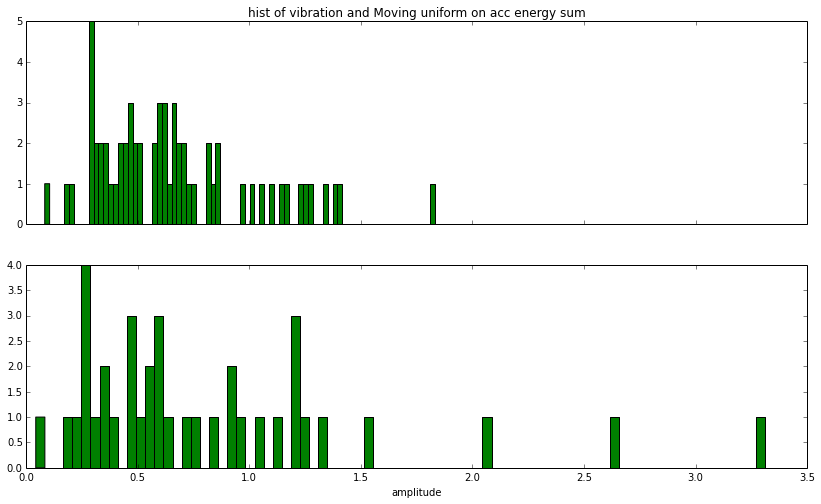

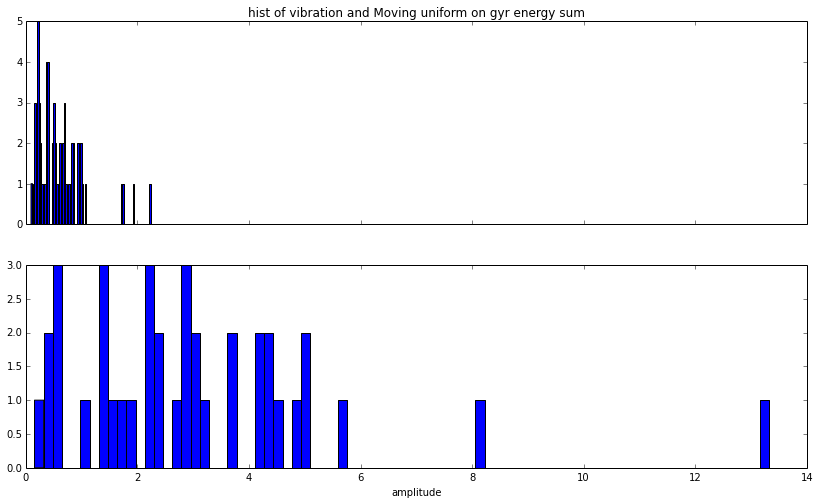

In [60]:
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

if __name__ == '__main__':
    
    fileNames = []
    #fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccEnergySum(sig1[:,6])
    acc_energyRange_sig2 = getAccEnergySum(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and Moving uniform on acc energy sum')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrEnergySum(energy_sig1[:,1])
    gyr_energyMax_sig2 = getGyrEnergySum(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of vibration and Moving uniform on gyr energy sum')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

#energy avg 上尝试不同的interval

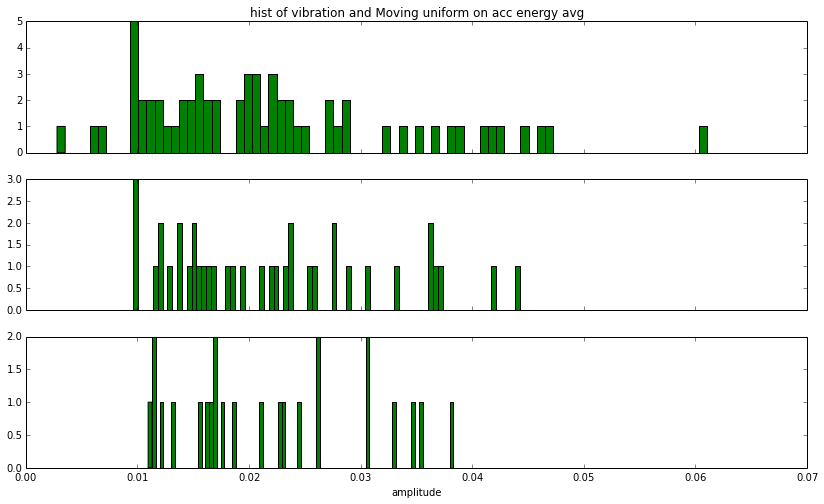

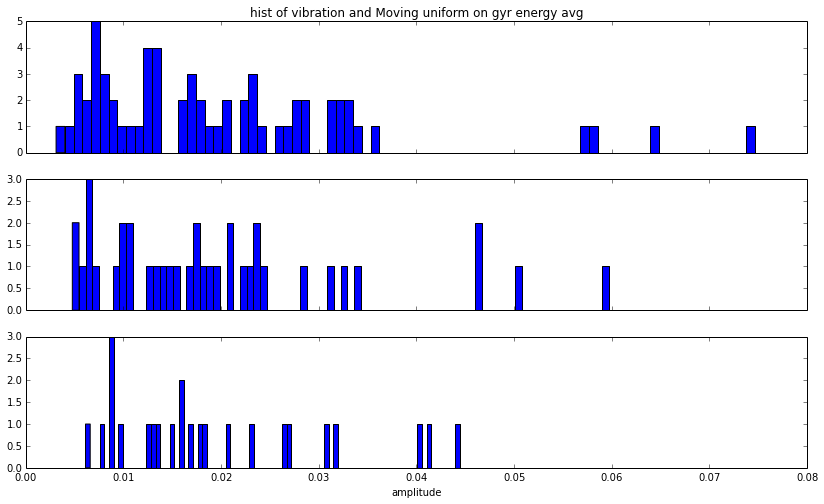

In [62]:
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

if __name__ == '__main__':
    
    fileNames = []
    #fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getAccEnergySum(sig1[:,6],30)/30.0
    acc_energyRange_sig2 = getAccEnergySum(sig1[:,6],50)/50.0
    acc_energyRange_sig3 = getAccEnergySum(sig1[:,6],80)/80.0
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[2].hist(acc_energyRange_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and Moving uniform on acc energy avg')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getGyrEnergySum(energy_sig1[:,1], 30)/30.0
    gyr_energyMax_sig2 = getGyrEnergySum(energy_sig1[:,1], 50)/50.0
    gyr_energyMax_sig3 = getGyrEnergySum(energy_sig1[:,1], 80)/80.0
    
    fig2, ax2 = plt.subplots(3, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[2].hist(gyr_energyMax_sig3, 80, facecolor='b')
    ax2[0].set_title('hist of vibration and Moving uniform on gyr energy avg')
    ax2[2].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

#比较vibration和moving uniform, moving speedup, 30个点为一个单位,关于acc enregy 的std

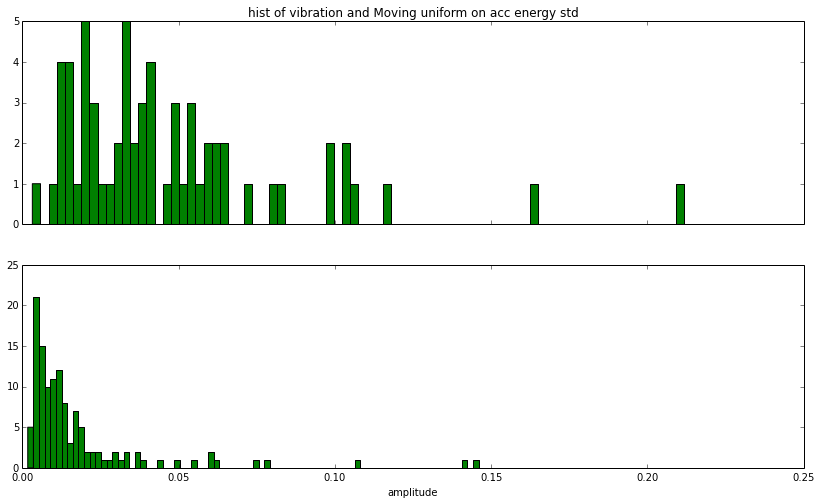

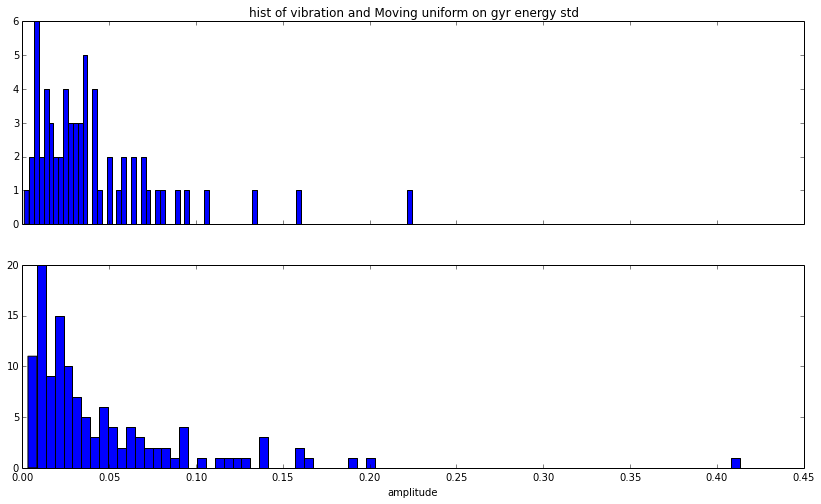

In [43]:
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getEnergyStd(sig1[:,6])
    acc_energyRange_sig2 = getEnergyStd(sig2[:,6])
    
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and Moving uniform on acc energy std')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getEnergyStd(energy_sig1[:,1])
    gyr_energyMax_sig2 = getEnergyStd(energy_sig2[:,1])
    fig2, ax2 = plt.subplots(2, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[0].set_title('hist of vibration and Moving uniform on gyr energy std')
    ax2[1].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

#在std上尝试不同interval, 范围基本不变

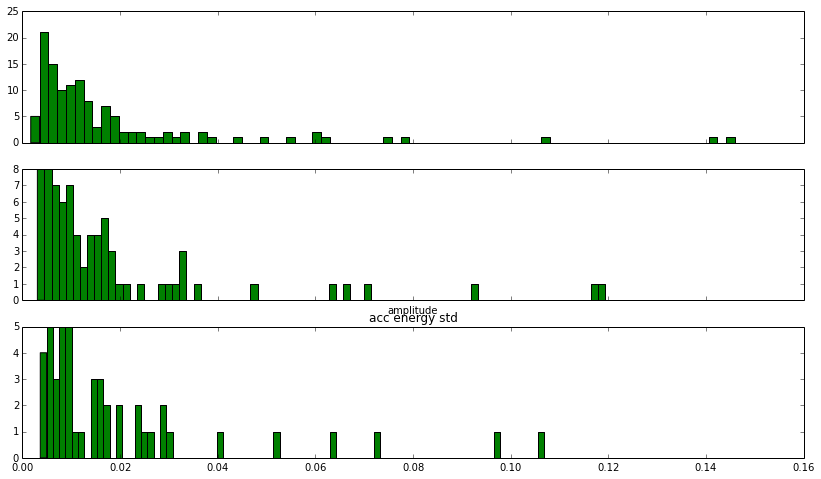

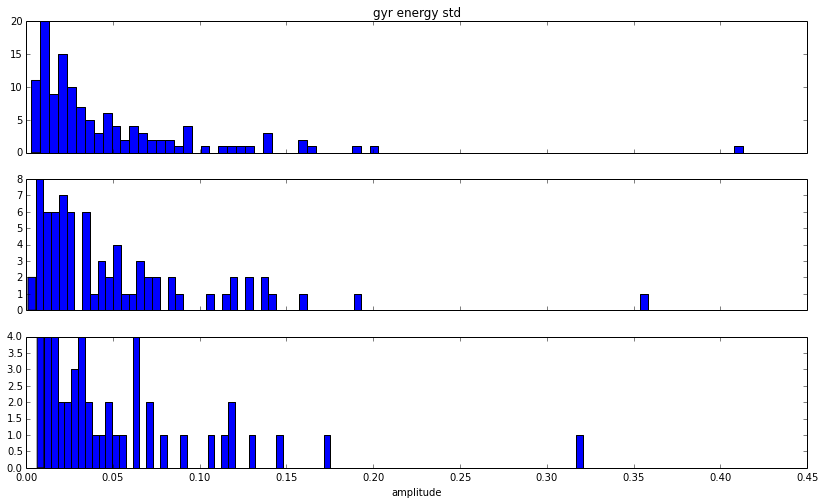

In [53]:
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(moveUniform_fileNames)
    fileNames.extend(vibration_fileNames)
    
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    
    
    
    acc_energyRange_sig1 = getEnergyStd(sig2[:,6], 30)
    acc_energyRange_sig2 = getEnergyStd(sig2[:,6], 50)
    acc_energyRange_sig3 = getEnergyStd(sig2[:,6], 80)
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(acc_energyRange_sig1, 80, facecolor='g')
    ax[1].hist(acc_energyRange_sig2, 80, facecolor='g')
    ax[2].hist(acc_energyRange_sig3, 80, facecolor='g')
    ax[1].set_xlabel('amplitude')
    ax[2].set_title('acc energy std')
    #ax[0].set_xlim([0,0.6])
    
    
    
    gyr_energyMax_sig1 = getEnergyStd(energy_sig2[:,1], 30)
    gyr_energyMax_sig2 = getEnergyStd(energy_sig2[:,1], 50)
    gyr_energyMax_sig3 = getEnergyStd(energy_sig2[:,1], 80)

    fig2, ax2 = plt.subplots(3, sharex=True)
    ax2[0].hist(gyr_energyMax_sig1, 80, facecolor='b')
    ax2[1].hist(gyr_energyMax_sig2, 80, facecolor='b')
    ax2[2].hist(gyr_energyMax_sig3, 80, facecolor='b')
    ax2[0].set_title('gyr energy std')
    ax2[2].set_xlabel('amplitude')
    #ax2[1].set_xlim([0, 2])
                                                          

# 关于gyr energy 的entrophy对vibration,still,moving进行比较, 当前数据上，区分较明显 

63
34


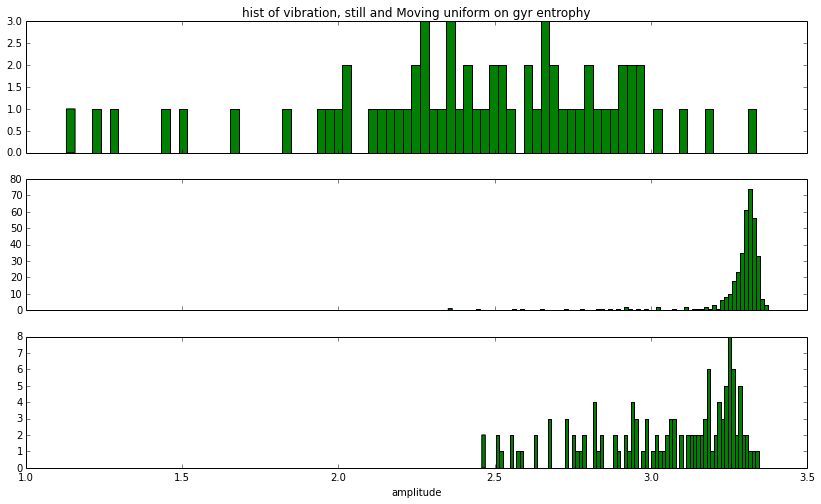

In [49]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    
    fileNames.extend(vibration_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    sig3 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    energy_sig3 = energyXYZ(sig3)
    
    
    
    interval = 30
    entrophy_sig1 = getEntrophy(energy_sig1[:,1],interval)
    entrophy_sig2 = getEntrophy(energy_sig2[:,1],interval)
    entrophy_sig3 = getEntrophy(energy_sig3[:,1],interval)
    
    print len(entrophy_sig1)
    print sum(entrophy_sig1<2.5)
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(entrophy_sig1, 80, facecolor='g')
    ax[1].hist(entrophy_sig2, 80, facecolor='g')
    ax[2].hist(entrophy_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration, still and Moving uniform on gyr entrophy')
    #ax[0].set_xlim([0,0.6])
    
    
    
    
                                                          

# 关于gyr energy 的entrophy对vibration,still,moving进行比较, 当前数据上，区分较明显    注：这里其实是entrophy /interval, 当interval发生变化的时候，整个幅度还是会变化，所以阈值很难设置（在不同interval下）

63
34


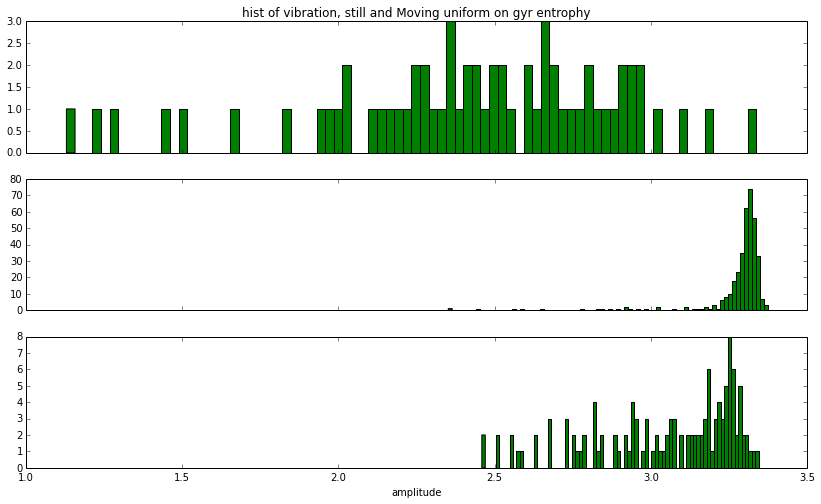

In [70]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    
    fileNames.extend(vibration_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    sig3 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    energy_sig3 = energyXYZ(sig3)
    
    
    
    interval = 30
    entrophy_sig1 = getEntrophy2(energy_sig1[:,1],interval)
    entrophy_sig2 = getEntrophy2(energy_sig2[:,1],interval)
    entrophy_sig3 = getEntrophy2(energy_sig3[:,1],interval)
    
    print len(entrophy_sig1)
    print sum(entrophy_sig1<2.5)
    
    #print entrophy_sig1
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(entrophy_sig1, 80, facecolor='g')
    ax[1].hist(entrophy_sig2, 80, facecolor='g')
    ax[2].hist(entrophy_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration, still and Moving uniform on gyr entrophy')
    #ax[0].set_xlim([0,0.6])
    
    
    
    
                                                          

# 关于gyr energy 的entrophy对vibration,still,moving进行比较, 当前数据上，区分较明显, 50个点为单位

38
18


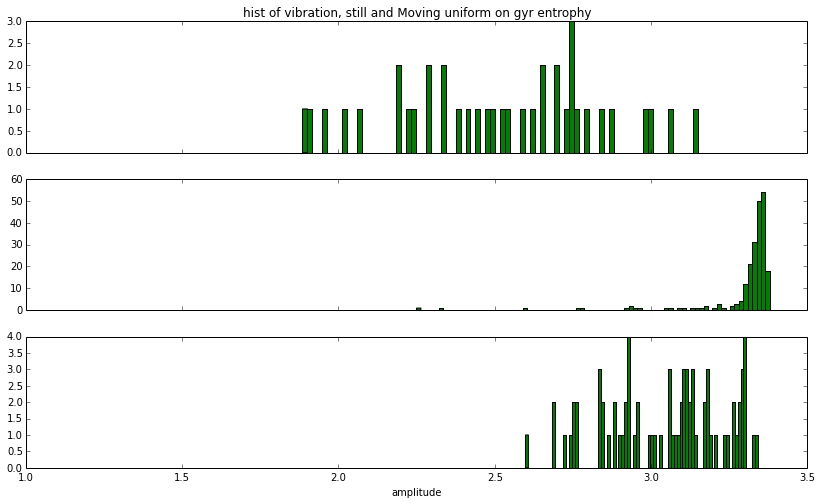

In [73]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    
    fileNames.extend(vibration_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    sig3 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    energy_sig3 = energyXYZ(sig3)
    
    
    
    
    interval = 50
    entrophy_sig1 = getEntrophy2(energy_sig1[:,1],interval)
    entrophy_sig2 = getEntrophy2(energy_sig2[:,1],interval)
    entrophy_sig3 = getEntrophy2(energy_sig3[:,1],interval)
    
    print len(entrophy_sig1)
    print sum(entrophy_sig1<2.5)
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(entrophy_sig1, 80, facecolor='g')
    ax[1].hist(entrophy_sig2, 80, facecolor='g')
    ax[2].hist(entrophy_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration, still and Moving uniform on gyr entrophy')
    ax[0].set_xlim([1,3.5])
    
    
    
    
                                                          

16
6


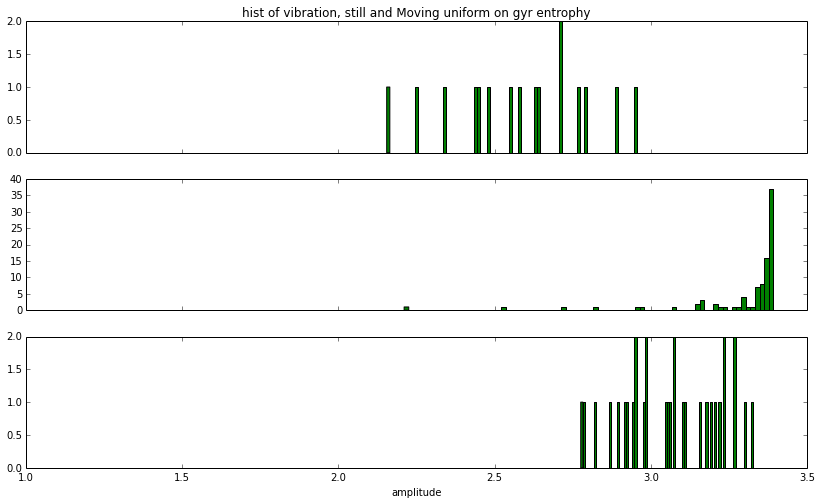

In [76]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    
    fileNames.extend(vibration_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    sig3 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    energy_sig3 = energyXYZ(sig3)
    
    
    
    
    interval = 120
    entrophy_sig1 = getEntrophy2(energy_sig1[:,1],interval)
    entrophy_sig2 = getEntrophy2(energy_sig2[:,1],interval)
    entrophy_sig3 = getEntrophy2(energy_sig3[:,1],interval)
    
    print len(entrophy_sig1)
    print sum(entrophy_sig1<2.5)
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(entrophy_sig1, 80, facecolor='g')
    ax[1].hist(entrophy_sig2, 80, facecolor='g')
    ax[2].hist(entrophy_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration, still and Moving uniform on gyr entrophy')
    ax[0].set_xlim([1,3.5])
    
    
    
    
                                                          

#基于acc energy的entrophy,在vibration，still,moving的较比
* 具有一定的区分性

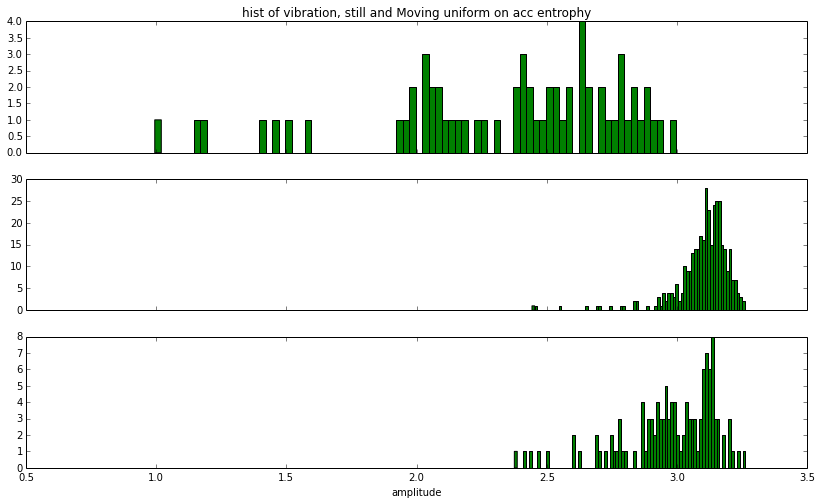

In [902]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    
    fileNames.extend(vibration_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    sig3 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    energy_sig3 = energyXYZ(sig3)
    
    entrophy_sig11 = getEntrophy(energy_sig1[:,1])
    entrophy_sig22 = getEntrophy(energy_sig2[:,1])
    entrophy_sig33 = getEntrophy(energy_sig3[:,1])
    
    
    entrophy_sig1 = getEntrophy(sig1[:,6])
    entrophy_sig2 = getEntrophy(sig2[:,6])
    entrophy_sig3 = getEntrophy(sig3[:,6])
    
    
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(entrophy_sig1, 80, facecolor='g')
    ax[1].hist(entrophy_sig2, 80, facecolor='g')
    ax[2].hist(entrophy_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration, still and Moving uniform on acc entrophy')
    #ax[0].set_xlim([0,0.6])
    
    
    
    
                                                          

vibration 与 moving的std比较

35


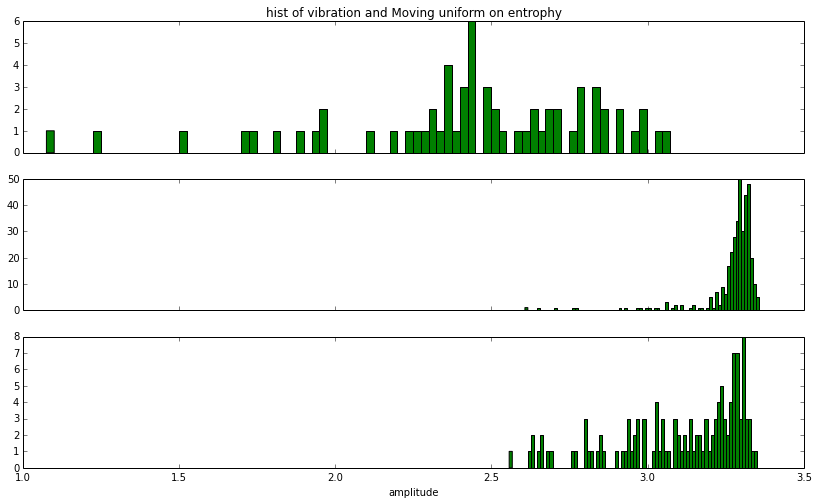

In [876]:
if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(moveUniform_fileNames)
    
    fileNames.extend(vibration_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    
    sig1 = res_specificClass[-1]
    sig2 = res_specificClass[0]
    sig3 = res_specificClass[1]
    
    energy_sig1 = energyXYZ(sig1)
    energy_sig2 = energyXYZ(sig2)
    energy_sig3 = energyXYZ(sig3)
    
    entrophy_sig11 = getEntrophy(energy_sig1[:,1])
    entrophy_sig22 = getEntrophy(energy_sig2[:,1])
    entrophy_sig33 = getEntrophy(energy_sig3[:,1])
    
    res1 = sig1[:,6] + energy_sig1[:,1]
    res2 = sig2[:,6] + energy_sig2[:,1]
    res3 = sig3[:,6] + energy_sig3[:,1]
    
    entrophy_sig1 = getEntrophy(res1)
    entrophy_sig2 = getEntrophy(res2)
    entrophy_sig3 = getEntrophy(res3)
    
    print sum(entrophy_sig1 < 2.5)
    
    #print sum(entrophy_sig1[entrophy_sig11>=2.5] < 2.5 )
    
    fig,ax = plt.subplots(3, sharex=True)
    ax[0].hist(entrophy_sig1, 80, facecolor='g')
    ax[1].hist(entrophy_sig2, 80, facecolor='g')
    ax[2].hist(entrophy_sig3, 80, facecolor='g')
    ax[2].set_xlabel('amplitude')
    ax[0].set_title('hist of vibration and Moving uniform on entrophy')
    #ax[0].set_xlim([0,0.6])
    
    
    
    
                                                          

In [877]:
def getfftEnergy(array, fft_len = 256):
    N = len(array)
    
    return np.log(np.abs(np.fft.fft(array, fft_len)))[:fft_len/2]

# 比较still, moving uniform, moving speedup, rotating, vibration的频谱能量图
* 重点比较still和moving uniform,但是确实很难观察出什么不同的地方

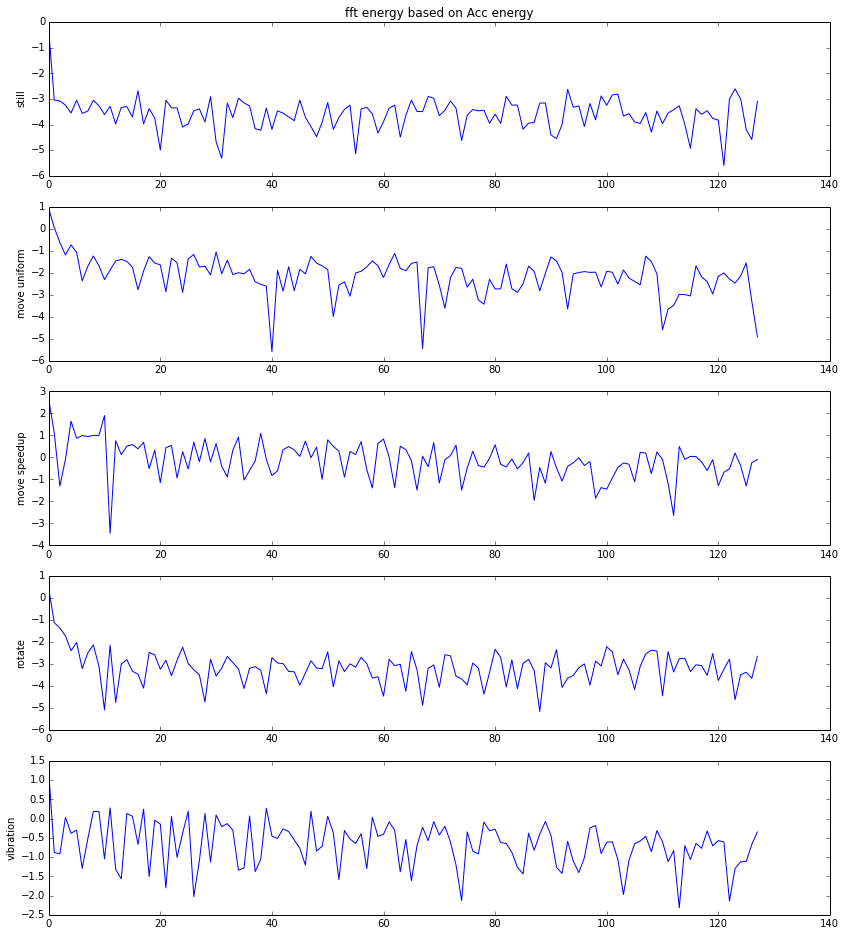

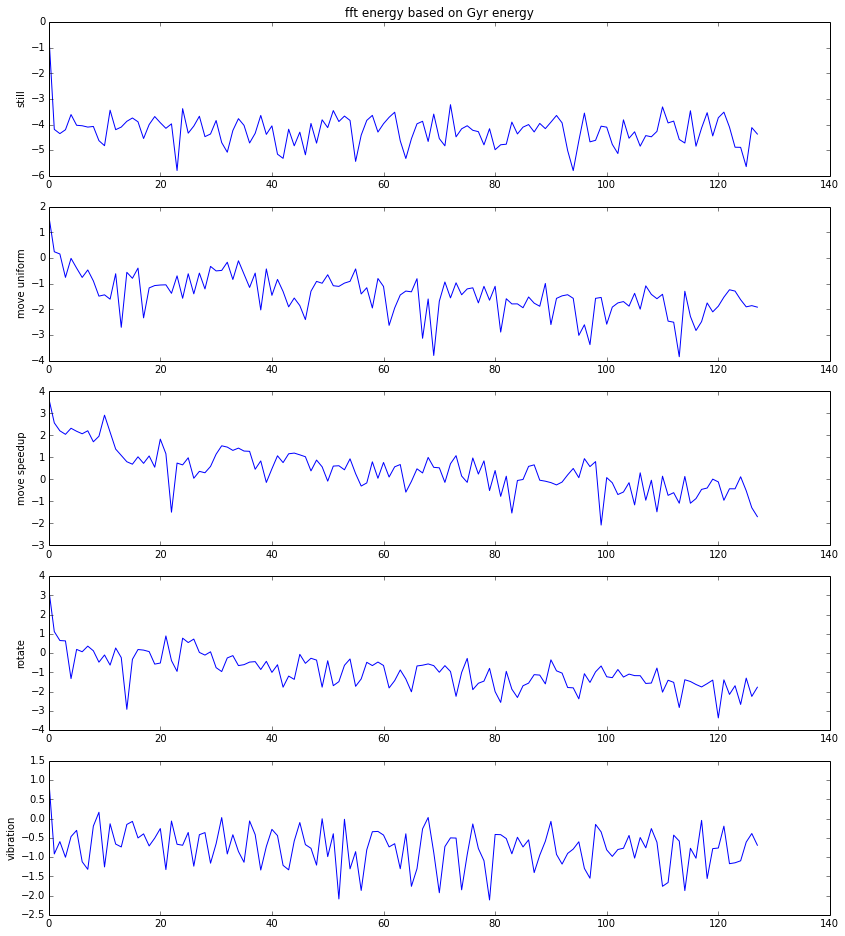

In [903]:
pylab.rcParams['figure.figsize'] = (14.0, 16.0)

if __name__ == '__main__':
    
    fileNames = []
    fileNames.extend(still_fileNames)
    #fileNames.extend(moveUniform_fileNames)
    fileNames.extend(moveSpeedup_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    #fileNames.extend(rotateMove_fileNames)
    fileNames.extend(vibration_fileNames)
    
    fileNames2 = []
    fileNames2.extend(moveUniform_fileNames)
    
    
    res_specificClass = concateMultiFiles(fileNames)
    res_specificClass2 = concateMultiFiles(fileNames2)
    
    sig_move_speedup = res_specificClass[1]
    sig_still = res_specificClass[0]
    sig_rotate = res_specificClass[2]
    sig_vibration = res_specificClass[-1]
    
    sig_move_uniform = res_specificClass2[1]
    
    
    energy_move_speedup = energyXYZ(sig_move_speedup)
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_still = energyXYZ(sig_still)
    energy_rotate = energyXYZ(sig_rotate)
    energy_vibration = energyXYZ(sig_vibration)
    
    
    accfft_move_speedup = getfftEnergy(sig_move_speedup[:,6])
    accfft_move_uniform = getfftEnergy(sig_move_uniform[:,6])
    accfft_still = getfftEnergy(sig_still[:,6])
    accfft_rotate = getfftEnergy(sig_rotate[:,6])
    accfft_vibration = getfftEnergy(sig_vibration[:,6])
    
    
    
    
    gyrfft_move_speedup = getfftEnergy(energy_move_speedup[:,1])
    gyrfft_move_uniform = getfftEnergy(energy_move_uniform[:,1])
    gyrfft_still = getfftEnergy(energy_still[:,1])
    gyrfft_rotate = getfftEnergy(energy_rotate[:,1])
    gyrfft_vibration = getfftEnergy(energy_vibration[:,1])
    
    
    #print accfft_move_speedup
    
    fig, ax = plt.subplots(5)
    ax[0].plot(accfft_still)
    ax[0].set_ylabel('still')
    ax[1].plot(accfft_move_uniform)
    ax[1].set_ylabel('move uniform')
    ax[2].plot(accfft_move_speedup)
    ax[2].set_ylabel('move speedup')
    ax[3].plot(accfft_rotate)
    ax[3].set_ylabel('rotate')
    ax[4].plot(accfft_vibration)
    ax[4].set_ylabel('vibration')
    ax[0].set_title('fft energy based on Acc energy')
    plt.show()
    
    
    fig2, ax2 = plt.subplots(5)
    ax2[0].plot(gyrfft_still)
    ax2[0].set_ylabel('still')
    ax2[1].plot(gyrfft_move_uniform)
    ax2[1].set_ylabel('move uniform')
    ax2[2].plot(gyrfft_move_speedup)
    ax2[2].set_ylabel('move speedup')
    ax2[3].plot(gyrfft_rotate)
    ax2[3].set_ylabel('rotate')
    ax2[4].plot(gyrfft_vibration)
    ax2[4].set_ylabel('vibration')
    ax2[0].set_title('fft energy based on Gyr energy')
    plt.show()
    
    
    

In [209]:
import random
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

def performance(true_labels, predict_labels):
    acc = sum(true_labels == predict_labels)/float(len(true_labels))
    recall = sum((true_labels == 1) & (predict_labels == 1))/float(sum(true_labels))
    precision = sum((true_labels == 1) & (predict_labels == 1))/float(sum(predict_labels))
    
    return [acc, precision, recall]


def extractFeatures(acc_energy_seg, gyr_energy_seg):
    acc_min = min(acc_energy_seg)
    acc_max = max(acc_energy_seg)
    acc_avg = np.mean(acc_energy_seg)
    acc_std = np.std(acc_energy_seg)
    acc_entrophy = calEntrophy(acc_energy_seg)
    
    gyr_min = min(gyr_energy_seg)
    gyr_max = max(gyr_energy_seg)
    gyr_avg = np.mean(gyr_energy_seg)
    gyr_std = np.std(gyr_energy_seg)
    gyr_entrophy = calEntrophy(gyr_energy_seg)
    
    features = np.array([acc_min, acc_max, acc_avg, acc_std, acc_entrophy, gyr_min, gyr_max, gyr_avg,\
                        gyr_std, gyr_entrophy])
    return features
    
    


if __name__ == '__main__':
    
    
    fileNames = []
    for i in range(1, 21):
        tmp = 'motion_vibration' + str(i) + '.txt'
        fileNames.append(tmp)
    
    for i in range(1, 17):
        tmp = 'motion_xyz_Move_uniform' + str(i) + '.txt'
        fileNames.append(tmp)
        
    #fileNames.extend(moveUniform_fileNames)
    fileNames.extend(rotateQuickUniform_fileNames)
    fileNames.extend(rotateSlowUniform_fileNames)
    
    fileNames2 = []
    for i in range(1, 16):
        tmp = 'motion_xyz_Move_speedup' + str(i) + '.txt'
        fileNames2.append(tmp)
    
    res_specificClass = concateMultiFiles(fileNames)
    res_specificClass2 = concateMultiFiles(fileNames2)
    
    
    sig_still = res_specificClass[0] 
    sig_vibration = res_specificClass[-1]
    sig_move_uniform = res_specificClass[1]
    
    
    sig_move_speedup = res_specificClass2[1]
    sig_move_speedup_still = res_specificClass2[0]
    
    
    
    energy_still = energyXYZ(sig_still)
    energy_vibration = energyXYZ(sig_vibration)
    energy_move_uniform = energyXYZ(sig_move_uniform)
    energy_move_speedup = energyXYZ(sig_move_speedup)
    energy_move_speedup_still =  energyXYZ(sig_move_speedup_still)
    
    
    
    acc_energy_still = sig_still[:,6]
    gyr_energy_still = energy_still[:,1]
    
    acc_energy_vibration = sig_vibration[:,6]
    gyr_energy_vibration = energy_vibration[:,1]
    
    acc_energy_move_uniform = sig_move_uniform[:,6]
    gyr_energy_move_uniform = energy_move_uniform[:,1]
    
    acc_energy_move_speedup = sig_move_speedup[:,6]
    gyr_energy_move_speedup = energy_move_speedup[:,1]
    
    acc_energy_move_speedup_still = sig_move_speedup_still[:, 6]
    gyr_energy_move_speedup_still = energy_move_speedup_still[:, 1]
    
    
    
    positive_samples = []
    negative_samples = []
    
    Labels = []
    
    
    sig_acc_positive = acc_energy_vibration
    sig_gyr_positive = gyr_energy_vibration
    
    sig_acc_negative = gyr_energy_move_speedup
    sig_acc_negative = np.concatenate((sig_acc_negative, acc_energy_move_uniform))
    sig_gyr_negative = gyr_energy_move_speedup
    sig_gyr_negative = np.concatenate((sig_gyr_negative, gyr_energy_move_uniform))
    
    
    """
    sig_acc_positive = acc_energy_move_uniform
    #sig_acc_positive = np.concatenate((sig_acc_positive, acc_energy_move_speedup))
    sig_gyr_positive = gyr_energy_move_uniform
    #sig_gyr_positive = np.concatenate((sig_gyr_positive, gyr_energy_move_speedup))
    
    
    sig_acc_negative = acc_energy_vibration
    sig_gyr_negative = gyr_energy_vibration
    #sig_acc_negative = acc_energy_still
    #sig_acc_negative = np.concatenate((sig_acc_negative, acc_energy_move_speedup_still))
    #sig_acc_negative = np.concatenate((sig_acc_negative, acc_energy_vibration))
    ##sig_gyr_negative = gyr_energy_still
    #sig_gyr_negative = np.concatenate((sig_gyr_negative, gyr_energy_move_speedup_still))
    #sig_gyr_negative = np.concatenate((sig_gyr_negative, gyr_energy_vibration))
    """
    
    N_positive = len(sig_acc_positive)
    N_negative = len(sig_gyr_negative)
    
    print "pos len: ", N_positive
    print "neg len: ", N_negative
    
    
    interval = 30
    for i in range(0, N_positive, interval):
        tmp_acc = sig_acc_positive[i:i+interval]
        tmp_gyr = sig_gyr_positive[i:i+interval]
        if len(tmp_acc)< interval:
            break;
        #tmp = getfftEnergy(tmp, fft_len = 32)
        entrophy_acc = calEntrophy(tmp_acc)
        entrophy_gyr = calEntrophy(tmp_gyr)
        
        tmp = extractFeatures(tmp_acc, tmp_gyr)
        # put label
        tmp = np.append(tmp, 1)
        
        
        if entrophy_acc < 2.8 or entrophy_gyr < 2.8:
            positive_samples.append(tmp)
        
    
    
    for i in range(0, N_negative, interval):
        tmp_acc = sig_acc_negative[i:i+interval]
        tmp_gyr = sig_gyr_negative[i:i+interval]
        if len(tmp_acc) < interval:
            break;
        #tmp = getfftEnergy(tmp, fft_len = 32)
        tmp = extractFeatures(tmp_acc, tmp_gyr)
        tmp = np.append(tmp, 0)
        
        negative_samples.append(tmp)
        
   
    
    
    positive_samples = np.array(positive_samples)
    negative_samples = np.array(negative_samples)
    
   
    
    print positive_samples.shape
    print negative_samples.shape
    
    
    samples = np.vstack((positive_samples, negative_samples))
    (n,m) = samples.shape
    print "size", n,m
    
    
    iters = 50
    acc_avg = 0.0
    pre_avg = 0.0
    recall_avg = 0.0
    
    p_svm = np.zeros(3)
    p_logi = np.zeros(3)
    p_neighbors = np.zeros(3)
    p_tree = np.zeros(3)
    p_forests = np.zeros(3)
    p_adaboost = np.zeros(3)
    
    for ii in range(iters):
        # Shuffle the samples
        index = range(n)
        random.shuffle(index)
        samples = samples[index,:]
    
    
    
        # Split data and labels
        Labels = samples[:,m-1]
        instances = samples[:, :m-1]
    
        # Split training data and test data
        train_ratio = 1.0/3
        train_num = int(n*train_ratio)
    
        train_samples = instances[:train_num, :]
        train_Labels = Labels[:train_num]
        test_samples = instances[train_num:, :]
        test_Labels = Labels[train_num:]
    
    
        # data normalization
        scaler = preprocessing.StandardScaler().fit(train_samples)
        train_samples = scaler.transform(train_samples)
    
        """
        print "mean: "
        data_mean = scaler.mean_
        for tt in data_mean:
            print tt, ",",
        print '\n\n'
    
        print "std: "
        data_std = scaler.std_
        for tt in data_std:
            print tt, ",",
        print '\n\n'
        """
    
        #clf = svm.SVC()
        clf = svm.LinearSVC()
        clf.fit(train_samples, train_Labels)
        
        clf_logi = LogisticRegression(C=100, penalty='l1', tol=0.01)
        clf_logi.fit(train_samples, train_Labels)
        
        n_neighbors = 5
        clf_KNN = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
        clf_KNN.fit(train_samples, train_Labels)
        
        clf_tree = tree.DecisionTreeClassifier()
        clf_tree.fit(train_samples, train_Labels)
        
        clf_forests = RandomForestClassifier(n_estimators=40)
        clf_forests.fit(train_samples, train_Labels)
        
        clf_adaboost = AdaBoostClassifier(n_estimators=10)
        clf_adaboost.fit(train_samples, train_Labels)
    
        """
        #############
        print "coef: "
        svm_coef = clf.coef_[0]
        for tt in svm_coef:
            print tt, ",",
        print '\n\n'
    
        print "intercept: ", clf.intercept_
        """
    
        train_Labels_predict = clf.predict(train_samples)
        #print "training accruacy:", sum(train_Labels_predict == train_Labels)/float(len(train_Labels))
    
        #for i in range(68):
        #    print sum(clf.coef_[0]*samples_scaled[i,:]) + clf.intercept_,
    
    
    
        test_samples = scaler.transform(test_samples)
    
        test_Labels_predict = clf.predict(test_samples)
        test_Labels_predict_logi = clf_logi.predict(test_samples)
        test_Labels_predict_KNN = clf_KNN.predict(test_samples)
        test_Labels_predict_tree = clf_tree.predict(test_samples)
        test_Labels_predict_forests = clf_forests.predict(test_samples)
        test_Labels_predict_adaboost = clf_adaboost.predict(test_samples)
    
        """
        [acc, precision, recall] = performance(test_Labels, test_Labels_predict)
        print "SVM Test, acc: ", acc, "  precision:", precision, "  recall:", recall
        [acc, precision, recall] = performance(test_Labels, test_Labels_predict_logi)
        print "logi Test, acc: ", acc, "  precision:", precision, "  recall:", recall
        [acc, precision, recall] = performance(test_Labels, test_Labels_predict_KNN)
        print "logi Test, acc: ", acc, "  precision:", precision, "  recall:", recall
    
        #print test_Labels
        #print "\n"
        #print test_Labels_predict
        acc_avg += acc
        pre_avg += precision
        recall_avg += recall
        """
        
        p_svm += performance(test_Labels, test_Labels_predict)
        #print "SVM Test, acc: ", acc, "  precision:", precision, "  recall:", recall
        p_logi += performance(test_Labels, test_Labels_predict_logi)
        #print "logi Test, acc: ", acc, "  precision:", precision, "  recall:", recall
        p_neighbors += performance(test_Labels, test_Labels_predict_KNN)
        #print "logi Test, acc: ", acc, "  precision:", precision, "  recall:", recall
        p_tree += performance(test_Labels, test_Labels_predict_tree)
        p_forests += performance(test_Labels, test_Labels_predict_forests)
        p_adaboost += performance(test_Labels, test_Labels_predict_adaboost)
        
    #acc_avg /= iters
    #pre_avg /= iters
    #recall_avg /= iters
    p_svm /= iters
    p_logi /= iters
    p_neighbors /= iters
    p_forests /= iters
    p_adaboost /= iters
    
    print "svm: ", p_svm
    print "logi: ", p_logi
    print "neighbors: ", p_neighbors
    print "tree: ", p_tree
    print "forests: ", p_forests
    print "adaboost: ", p_adaboost
    #print "Test, acc: ", acc_avg, "  precision:", pre_avg, "  recall:", recall_avg

pos len:  1886
neg len:  2905
(59, 11)
(96, 11)
size 155 11
svm:  [ 0.92076923  0.89924463  0.89442525]
logi:  [ 0.91230769  0.88503561  0.8899206 ]
neighbors:  [ 0.9125      0.86609351  0.91451231]
tree:  [ 43.48076923  42.2022925   40.47945123]
forests:  [ 0.89846154  0.89168744  0.83740352]
adaboost:  [ 0.87346154  0.85679216  0.80378679]
